Import libraries

In [ ]:
import pandas as pd
#pd.set_option('max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

import missingno
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Load data set

In [ ]:
raw_data = pd.read_excel("/content/raw_data.xlsx")
flooded_streets = pd.read_excel("/content/flooded_road.xlsx")
density_of_districts = pd.read_excel("/content/density_of_hcm.xlsx")
#rs_price = pd.read_excel("/content/RS_price_table.xlsx")

Clean data

**1.** **Step 1**: Tách address field thành 2 cột street_name và district_name.

Tách details field thành 4 cột bao gồm street_width (chiều ngang mặt đường), floor (số tầng), bedroom (số phòng ngủ), garage (chỗ để xe) - dummy variable

In [ ]:
# Create street, ward, district, street_width, floor, bed_room, garage
street_name = []
district_name = []

for i in raw_data.Address:
  if "Thủ Đức" in i:
    if 'Đường số' in i:
      l = i.split(', ')
      street = [', '.join(l[0:2])]
      street_name.append(street)
    else:
      l= i.split(', ')
      street = l[0]
      street_name.append(street)
    district_name.append(['Thủ Đức'])
  else:
    l= i.split(', ')
    street = l[0]
    street_name.append(street)
    district_name.append(l[-2])

# Lot Area
lot_area = []
for i in raw_data['Lot_area']:
    l = i.split(' ')[2]
    lot_area.append(l)

# Details
street_width = []
bed_room = []
garage = []
floor = []
for i in raw_data.Details:
  if 'chỗ để xe' in i:
    garage.append(1)
    i1=i.split('chỗ để xe')[0]
    if 'phòng ngủ' in i1:
      i2 = i1.split(' ')[-3]
      if 'lầu' in i2:
        bed = i2.split('lầu')[-1]
      else:
        bed = i2.split('m')[-1]
      bed_room.append(bed)
    else:
      bed_room.append(None)
  else:
    garage.append(0)
    if 'phòng ngủ' in i:
      i1 = i.split(' ')[-3]
      if 'lầu' in i1:
        bed = i1.split('lầu')[-1]
      else:
        bed = i1.split('m')[-1]
      bed_room.append(bed)
    else:
      bed_room.append(None)

for i in raw_data.Details:
  if 'm' in i:
    i1 = i.split('m')
    width = i1[0]
    street_width.append(width)
    if 'lầu' in i:
      floor_num = i1[1].split(' ')[0]
      floor.append(floor_num)
    else:
      floor.append(None)
  else:
    street_width.append(None)
    if 'lầu' in i:
      floor_num = i.split(' ')[0]
      floor.append(floor_num)
    else:
      floor.append(None)


# Price
price = []
for i in raw_data.Price:
    l = i.split(' ')[1:3]
    l = ' '.join(l)
    price.append(l)

In [ ]:
print(len(street_name), len(district_name), len(lot_area), len(street_width), \
      len(bed_room), len(garage), len(floor), len(price))

5640 5640 5640 5640 5640 5640 5640 5640


**2. Step 2**: concatenate 8 lists of variables into one dataframe

In [ ]:
df = pd.DataFrame(list(zip(street_name, district_name, lot_area, street_width, \
                           bed_room, garage, floor, price)), columns =['Street_name', \
                          'District_name', 'Lot_area', 'Street_width', 'Bed_room', 'Garage', \
                          'Floor', 'Price'])

**3. Step 3**: Dropna

<Axes: >

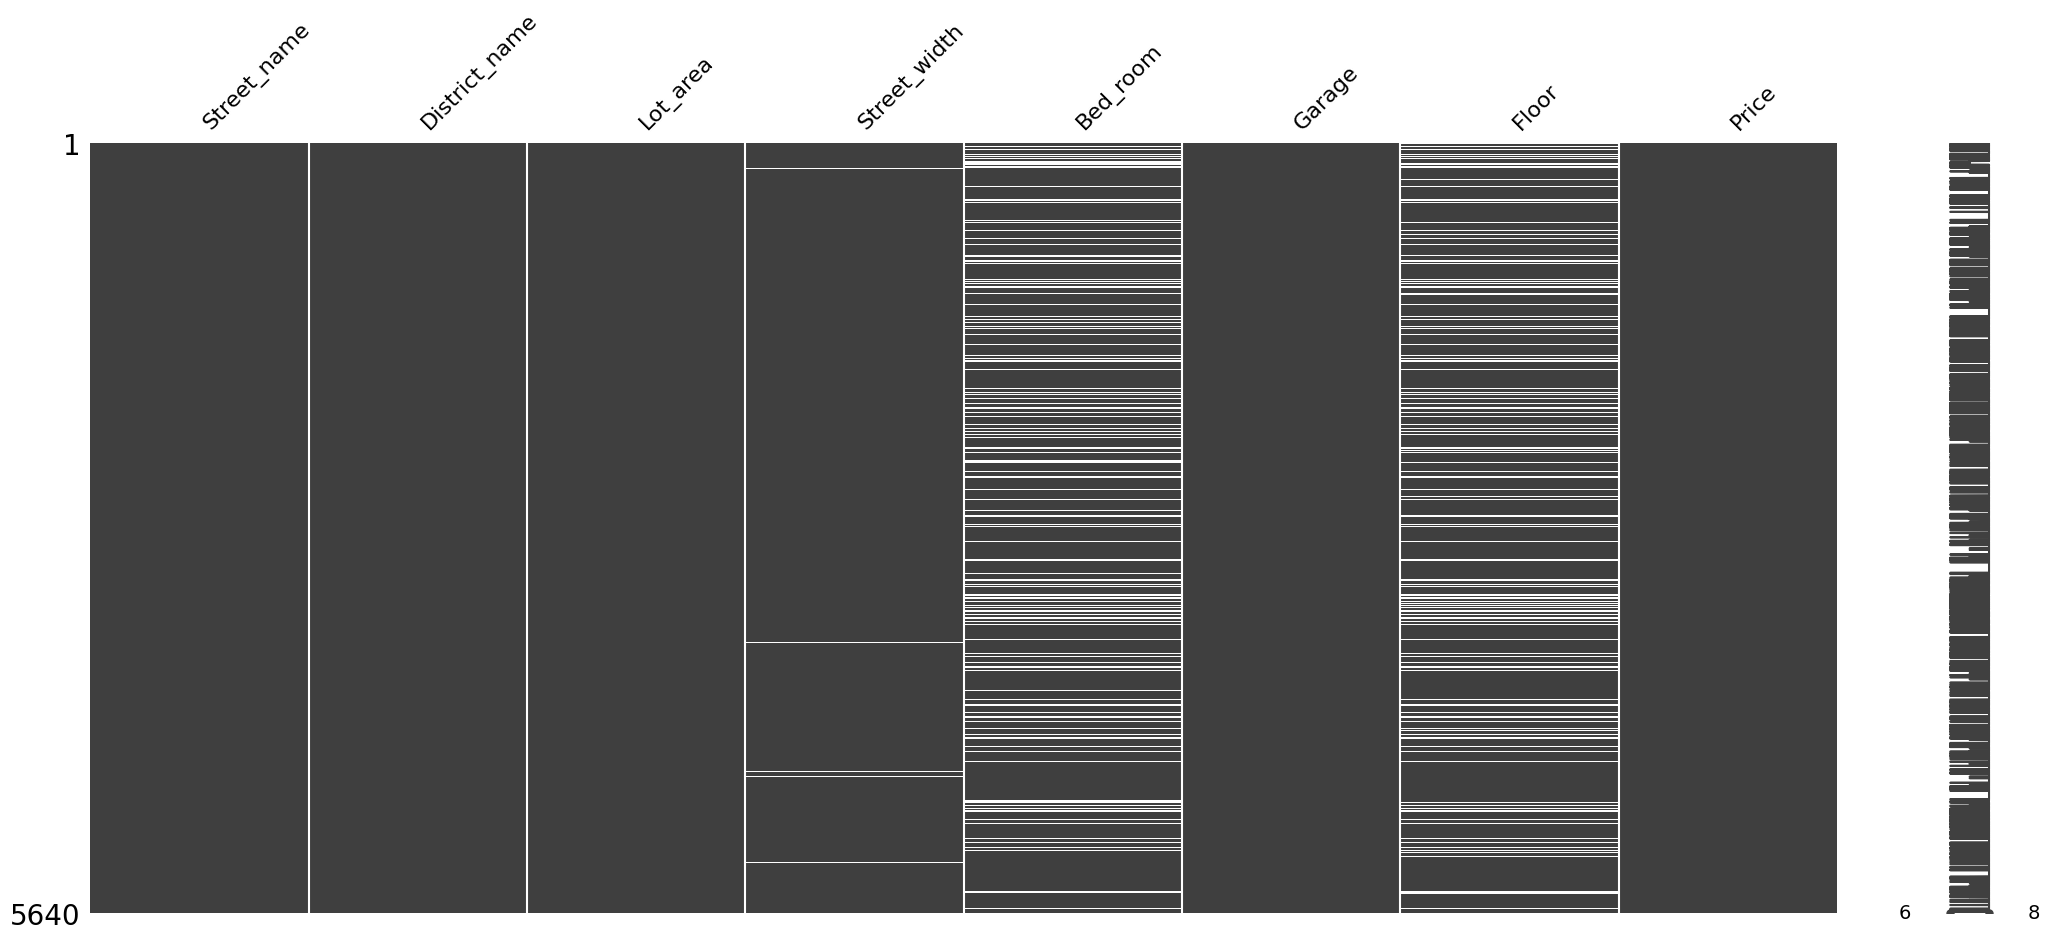

In [ ]:
import missingno

missingno.matrix(df)
#plt.savefig('missing_value.png')

In [ ]:
def count_missing(df):
  print(df.isnull().sum().sum())
  print(round((4025*4-df.isnull().sum().sum())/(4025*4),2)*100)
count_missing(df)

2132
87.0


In [ ]:
def find_missing(df):
  print(df.isnull().sum())

find_missing(df)

Street_name         0
District_name       0
Lot_area            0
Street_width       51
Bed_room         1032
Garage              0
Floor            1049
Price               0
dtype: int64


In [ ]:
df = df.dropna()
df.shape

(4464, 8)

**4. Step 4**: Convert all data types into string

In [ ]:
df.Street_name = df.Street_name.astype(str)
df.District_name = df.District_name.astype(str)
df.Garage = df.Garage.astype(str)

<ipython-input-10-1f5447c96c2c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Street_name = df.Street_name.astype(str)
<ipython-input-10-1f5447c96c2c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.District_name = df.District_name.astype(str)
<ipython-input-10-1f5447c96c2c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [ ]:
df.dtypes

Street_name      object
District_name    object
Lot_area         object
Street_width     object
Bed_room         object
Garage           object
Floor            object
Price            object
dtype: object

**5. Step 5**: Reset index

In [ ]:
df.index = pd.RangeIndex(len(df.index))
df.index = range(len(df.index))

**6. Step 6**: Change formats of variables for dataframe's synchronization

In [ ]:
for i in df.index:
    if "['Thủ Đức']" in df.loc[i,'District_name']:
      df.loc[i,'District_name'] = 'Thành phố Thủ Đức'
    char_list_street = [*(df.loc[i,'Street_name'])]
    if "[" in char_list_street:
      chart_list_street = char_list_street[2:(len(char_list_street)-2)]
      df.loc[i,'Street_name'] = df.loc[i,'Street_name'].replace("['", "")
      df.loc[i,'Street_name'] = df.loc[i,'Street_name'].replace("']", "")
      df.loc[i,'Street_name'] = df.loc[i,'Street_name'].split(',')[0]

In [ ]:
for i in df.index:
  if "," in df.loc[i,'Street_width']:
    df.loc[i,'Street_width'] = df.loc[i,'Street_width'].replace(",", ".")
  if "," in df.loc[i,'Price']:
    df.loc[i,'Price'] = df.loc[i,'Price'].replace(",", ".")
  if "." in df.loc[i,'Lot_area']:
    df.loc[i,'Lot_area'] = df.loc[i,'Lot_area'].replace(".", "")

In [ ]:
price_list = df.Price
lot_area_list = df.Lot_area
price = []

k=0
for i in price_list:
  if 'triệu / m2' in i:
    item = round((float(i.split(' ')[0]) * int(lot_area_list[k]) / 1000),2)
    price.append(item)
  elif 'tỷ' in i:
    item = float(i.split(' ')[0])
    price.append(item)
  elif str(i.split(' ')[1]) == 'triệu':
    item = round((float(i.split(' ')[0]) / 1000),2)
    price.append(item)
  else:
    price.append('Unknown')
  k+=1
print(price)

df.Price = price

[18.0, 3.73, 12.0, 33.0, 0.73, 5.95, 7.5, 19.5, 11.3, 6.6, 25.8, 70.0, 12.8, 2.48, 1.12, 3.9, 0.77, 0.77, 2.5, 2.5, 3.8, 2.495, 2.65, 1.25, 2.69, 9.0, 86.0, 1.75, 7.8, 5.3, 2.9, 638.0, 3.7, 5.9, 12.5, 3.2, 2.1, 7.25, 3.1, 11.2, 1.25, 13.0, 0.11, 7.5, 7.2, 7.2, 8.75, 5.3, 12.5, 5.35, 8.95, 17.9, 7.8, 7.8, 4.19, 9.2, 13.7, 2.9, 1.34, 1.65, 7.5, 7.8, 8.7, 6.7, 13.0, 0.02, 1.1, 12.9, 16.0, 5.6, 38.0, 24.6, 320.0, 290.0, 16.0, 48.0, 7.9, 27.9, 7.3, 26.0, 210.0, 11.9, 15.9, 8.5, 6.8, 23.0, 50.0, 17.0, 18.3, 9.9, 7.0, 1.02, 1.57, 1.49, 29.5, 35.0, 27.0, 4.8, 1.35, 0.16, 6.9, 17.0, 11.5, 34.0, 3.5, 13.0, 7.95, 15.9, 28.0, 59.5, 16.0, 149.0, 26.0, 4.5, 4.0, 13.4, 14.0, 19.0, 6.49, 5.25, 4.5, 4.25, 12.0, 22.9, 5.3, 28.0, 89.0, 17.0, 32.0, 25.0, 9.5, 22.0, 9.0, 1050.0, 370.0, 550.0, 300.0, 280.0, 0.9, 35.0, 16.5, 13.5, 9.4, 11.888, 30.0, 13.5, 334.0, 163.0, 16.0, 39.0, 30.0, 73.0, 23.0, 17.4, 13.5, 2.72, 6.1, 10.5, 5.35, 4.25, 4.73, 4.6, 4.75, 4.8, 4.35, 17.8, 20.0, 39.0, 52.0, 13.8, 3.45, 4.3, 5

In [ ]:
df.drop(df[df['Price'] == 'Unknown'].index, inplace=True)

In [ ]:
print(df.to_string())

                      Street_name      District_name Lot_area Street_width Bed_room Garage Floor    Price
0               Đường Cao Văn Lầu             Quận 6       92           20        4      1     4     18.0
1            Đường Thoại Ngọc Hầu       Quận Tân Phú       36            7        2      0     2     3.73
2            Đường Phan Chu Trinh       Quận Tân Phú       78            8        3      1     3     12.0
3             Đường Lê Quang Định    Quận Bình Thạnh      150           30        5      0     3     33.0
4         Đường Tân Chánh Hiệp 18            Quận 12       78            8        2      0     1     0.73
5            Đường Huỳnh Tấn Phát       Huyện Nhà Bè       55            6        4      0     3     5.95
6            Đường Huỳnh Tấn Phát       Huyện Nhà Bè       70            9        5      1     4      7.5
7             Đường Phan Đăng Lưu    Quận Bình Thạnh      120            6        5      1     4     19.5
8             Đường Nơ Trang Long    Quận Bình

**7. Step 7**: Append flooded road field and district density field into dataframe

In [ ]:
print(flooded_streets.to_string())

                    street           district
0           Đường Calmette             Quận 1
1   Đường Nguyễn Thái Bình             Quận 1
2           Đường Cô Giang             Quận 1
3         Đường Hồ Hảo Hớn             Quận 1
4   Đường Nguyễn Duy Trinh             Quận 2
5     Đường Lương Định Của             Quận 2
6          Đường Thảo Điền             Quận 2
7         Đường Quốc Hương             Quận 2
8            Đường Kỳ Đồng             Quận 3
9        Đường Đoàn Văn Bơ             Quận 4
10        Đường Vĩnh Khánh             Quận 4
11        Đường Hoàng Diệu             Quận 4
12    Đường Dương Tử Giang             Quận 5
13     Đường Trần Hưng Đạo             Quận 5
14       Đường Nguyễn Biểu             Quận 5
15     Đường Nguyễn Văn Cừ             Quận 5
16     Đường Đỗ Ngọc Thạch             Quận 5
17           Đường Gò Công             Quận 5
18    Đường An Dương Vương             Quận 6
19           Đường Tân Hóa             Quận 6
20   Đường Mai Xuân Thưởng        

In [ ]:
flooded_road = []
for i in df.index:
  if df.loc[i,'Street_name'] in list(flooded_streets.street):
    ind_list = flooded_streets[flooded_streets['street']==df.loc[i,'Street_name']].index.values
    k=0
    for j in ind_list:
      if flooded_streets.iloc[j,1] == df.loc[i,'District_name']:
        flooded_road.append(1)
        break
      else:
        if k<len(ind_list)-1:
          k+=1
        else:
          flooded_road.append(0)
  else:
    flooded_road.append(0)

In [ ]:
df['Flooded_road'] = flooded_road

In [ ]:
df

Street_name    District_name Lot_area Street_width Bed_room  \
0           Đường Cao Văn Lầu           Quận 6       92           20        4   
1        Đường Thoại Ngọc Hầu     Quận Tân Phú       36            7        2   
2        Đường Phan Chu Trinh     Quận Tân Phú       78            8        3   
3         Đường Lê Quang Định  Quận Bình Thạnh      150           30        5   
4     Đường Tân Chánh Hiệp 18          Quận 12       78            8        2   
...                       ...              ...      ...          ...      ...   
4459   Đường Nguyễn Văn Lượng      Quận Gò Vấp      110           40        5   
4460         Đường Thống Nhất      Quận Gò Vấp      120           25        4   
4461         Đường Minh Phụng           Quận 6       90            7        2   
4462       Đường Lê Thị Riêng          Quận 12       58            5        2   
4463       Đường Đinh Bộ Lĩnh  Quận Bình Thạnh       73           20        8   

     Garage Floor Price  Flooded_road  
0         1     4  18.0             0  
1         0     2  3.73             0  
2         1     3  12.0             0  
3         0     3  33.0             0  
4         0     1  0.73             0  
...     ...   ...   ...           ...  
4459      0     2  14.4             0  
4460      0     2  14.5             0  
4461      1     1  11.5             0  
4462      0     2   3.8             0  
4463      0     8  35.0             0  

[4458 rows x 9 columns]

**8. Step 8**: Append density of district into dataframe

In [ ]:
density_of_districts = density_of_districts[['district_name', 'density']]
density_of_districts.columns = ['District_name', 'Density']
df1 = df.merge(density_of_districts, how='left', on='District_name')
print(df1.to_string())

                      Street_name      District_name Lot_area Street_width Bed_room Garage Floor    Price  Flooded_road  Density
0               Đường Cao Văn Lầu             Quận 6       92           20        4      1     4     18.0             0   32.439
1            Đường Thoại Ngọc Hầu       Quận Tân Phú       36            7        2      0     2     3.73             0   30.146
2            Đường Phan Chu Trinh       Quận Tân Phú       78            8        3      1     3     12.0             0   30.146
3             Đường Lê Quang Định    Quận Bình Thạnh      150           30        5      0     3     33.0             0   23.998
4         Đường Tân Chánh Hiệp 18            Quận 12       78            8        2      0     1     0.73             0   11.745
5            Đường Huỳnh Tấn Phát       Huyện Nhà Bè       55            6        4      0     3     5.95             1    2.060
6            Đường Huỳnh Tấn Phát       Huyện Nhà Bè       70            9        5      1     4 

In [ ]:
df1

Street_name    District_name Lot_area Street_width Bed_room  \
0           Đường Cao Văn Lầu           Quận 6       92           20        4   
1        Đường Thoại Ngọc Hầu     Quận Tân Phú       36            7        2   
2        Đường Phan Chu Trinh     Quận Tân Phú       78            8        3   
3         Đường Lê Quang Định  Quận Bình Thạnh      150           30        5   
4     Đường Tân Chánh Hiệp 18          Quận 12       78            8        2   
...                       ...              ...      ...          ...      ...   
4453   Đường Nguyễn Văn Lượng      Quận Gò Vấp      110           40        5   
4454         Đường Thống Nhất      Quận Gò Vấp      120           25        4   
4455         Đường Minh Phụng           Quận 6       90            7        2   
4456       Đường Lê Thị Riêng          Quận 12       58            5        2   
4457       Đường Đinh Bộ Lĩnh  Quận Bình Thạnh       73           20        8   

     Garage Floor Price  Flooded_road  Density  
0         1     4  18.0             0   32.439  
1         0     2  3.73             0   30.146  
2         1     3  12.0             0   30.146  
3         0     3  33.0             0   23.998  
4         0     1  0.73             0   11.745  
...     ...   ...   ...           ...      ...  
4453      0     2  14.4             0   34.360  
4454      0     2  14.5             0   34.360  
4455      1     1  11.5             0   32.439  
4456      0     2   3.8             0   11.745  
4457      0     8  35.0             0   23.998  

[4458 rows x 10 columns]

**10. Step 9**: Set up data type for each variable

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4458 entries, 0 to 4457
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Street_name    4458 non-null   object 
 1   District_name  4458 non-null   object 
 2   Lot_area       4458 non-null   object 
 3   Street_width   4458 non-null   object 
 4   Bed_room       4458 non-null   object 
 5   Garage         4458 non-null   object 
 6   Floor          4458 non-null   object 
 7   Price          4458 non-null   object 
 8   Flooded_road   4458 non-null   int64  
 9   Density        4458 non-null   float64
dtypes: float64(1), int64(1), object(8)
memory usage: 383.1+ KB


In [ ]:
categorical_features=['Street_name', 'District_name']
numerical_features=list(set(df1.columns)-set(categorical_features))

df1[numerical_features] = df1[numerical_features].astype(float)
print(len(categorical_features))
print(len(numerical_features))

2
8


In [ ]:
price = list(df1.Price)
price = [ round(elem,1) for elem in price]
print(price)


[18.0, 3.7, 12.0, 33.0, 0.7, 6.0, 7.5, 19.5, 11.3, 6.6, 25.8, 70.0, 12.8, 2.5, 1.1, 3.9, 0.8, 0.8, 2.5, 2.5, 3.8, 2.5, 2.6, 1.2, 2.7, 9.0, 86.0, 1.8, 7.8, 5.3, 2.9, 638.0, 3.7, 5.9, 12.5, 3.2, 2.1, 7.2, 3.1, 11.2, 1.2, 13.0, 0.1, 7.5, 7.2, 7.2, 8.8, 5.3, 12.5, 5.3, 8.9, 17.9, 7.8, 7.8, 4.2, 9.2, 13.7, 2.9, 1.3, 1.6, 7.5, 7.8, 8.7, 6.7, 13.0, 0.0, 1.1, 12.9, 16.0, 5.6, 38.0, 24.6, 320.0, 290.0, 16.0, 48.0, 7.9, 27.9, 7.3, 26.0, 210.0, 11.9, 15.9, 8.5, 6.8, 23.0, 50.0, 17.0, 18.3, 9.9, 7.0, 1.0, 1.6, 1.5, 29.5, 35.0, 27.0, 4.8, 1.4, 0.2, 6.9, 17.0, 11.5, 34.0, 3.5, 13.0, 8.0, 15.9, 28.0, 59.5, 16.0, 149.0, 26.0, 4.5, 4.0, 13.4, 14.0, 19.0, 6.5, 5.2, 4.5, 4.2, 12.0, 22.9, 5.3, 28.0, 89.0, 17.0, 32.0, 25.0, 9.5, 22.0, 9.0, 1050.0, 370.0, 550.0, 300.0, 280.0, 0.9, 35.0, 16.5, 13.5, 9.4, 11.9, 30.0, 13.5, 334.0, 163.0, 16.0, 39.0, 30.0, 73.0, 23.0, 17.4, 13.5, 2.7, 6.1, 10.5, 5.3, 4.2, 4.7, 4.6, 4.8, 4.8, 4.3, 17.8, 20.0, 39.0, 52.0, 13.8, 3.5, 4.3, 5.0, 6.0, 7.6, 0.7, 9.6, 20.0, 6.5, 6.9, 3

In [ ]:
df1.Price = price

In [ ]:
df1[['Lot_area', 'Bed_room', 'Garage', 'Floor', 'Flooded_road', 'Street_width']] = df1[['Lot_area', 'Bed_room', 'Garage', 'Floor', 'Flooded_road', 'Street_width']].astype(int)

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4458 entries, 0 to 4457
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Street_name    4458 non-null   object 
 1   District_name  4458 non-null   object 
 2   Lot_area       4458 non-null   int64  
 3   Street_width   4458 non-null   int64  
 4   Bed_room       4458 non-null   int64  
 5   Garage         4458 non-null   int64  
 6   Floor          4458 non-null   int64  
 7   Price          4458 non-null   float64
 8   Flooded_road   4458 non-null   int64  
 9   Density        4458 non-null   float64
dtypes: float64(2), int64(6), object(2)
memory usage: 383.1+ KB


In [ ]:
# def getIndexes(dfObj, value):
#     ''' Get index positions of value in dataframe i.e. dfObj.'''
#     listOfPos = list()
#     # Get bool dataframe with True at positions where the given value exists
#     result = dfObj.isin([value])
#     # Get list of columns that contains the value
#     seriesObj = result.any()
#     columnNames = list(seriesObj[seriesObj == True].index)
#     # Iterate over list of columns and fetch the rows indexes where value exists
#     for col in columnNames:
#         rows = list(result[col][result[col] == True].index)
#         for row in rows:
#             listOfPos.append((row, col))
#     # Return a list of tuples indicating the positions of value in the dataframe
#     return listOfPos
# listOfPositions = getIndexes(df1, '')
# listOfPositions

**9. Step 10:** Detect and remove outliers of variables

In [ ]:
df1[numerical_features].describe()

Bed_room       Garage  Flooded_road        Floor  Street_width  \
count  4458.000000  4458.000000   4458.000000  4458.000000   4458.000000   
mean      6.129879     0.501795      0.115074     3.240691     11.453567   
std      11.539514     0.500053      0.319147     2.573084      9.259344   
min       1.000000     0.000000      0.000000     1.000000      0.000000   
25%       3.000000     0.000000      0.000000     2.000000      5.000000   
50%       4.000000     1.000000      0.000000     3.000000      8.000000   
75%       5.000000     1.000000      0.000000     4.000000     15.000000   
max     192.000000     1.000000      1.000000    41.000000    120.000000   

           Density     Lot_area        Price  
count  4458.000000  4458.000000  4458.000000  
mean     23.261771   165.056528    27.586608  
std      12.345034   390.977714    78.871401  
min       1.063000     1.000000     0.000000  
25%      11.745000    60.000000     4.000000  
50%      23.998000    80.000000     8.200000  
75%      34.360000   135.000000    22.000000  
max      41.745000  7314.000000  2000.000000

<ipython-input-32-84ce6cdf6d95>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1[i])
<ipython-input-32-84ce6cdf6d95>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1[i])
<ipython-input-32-84ce6cdf6d95>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v

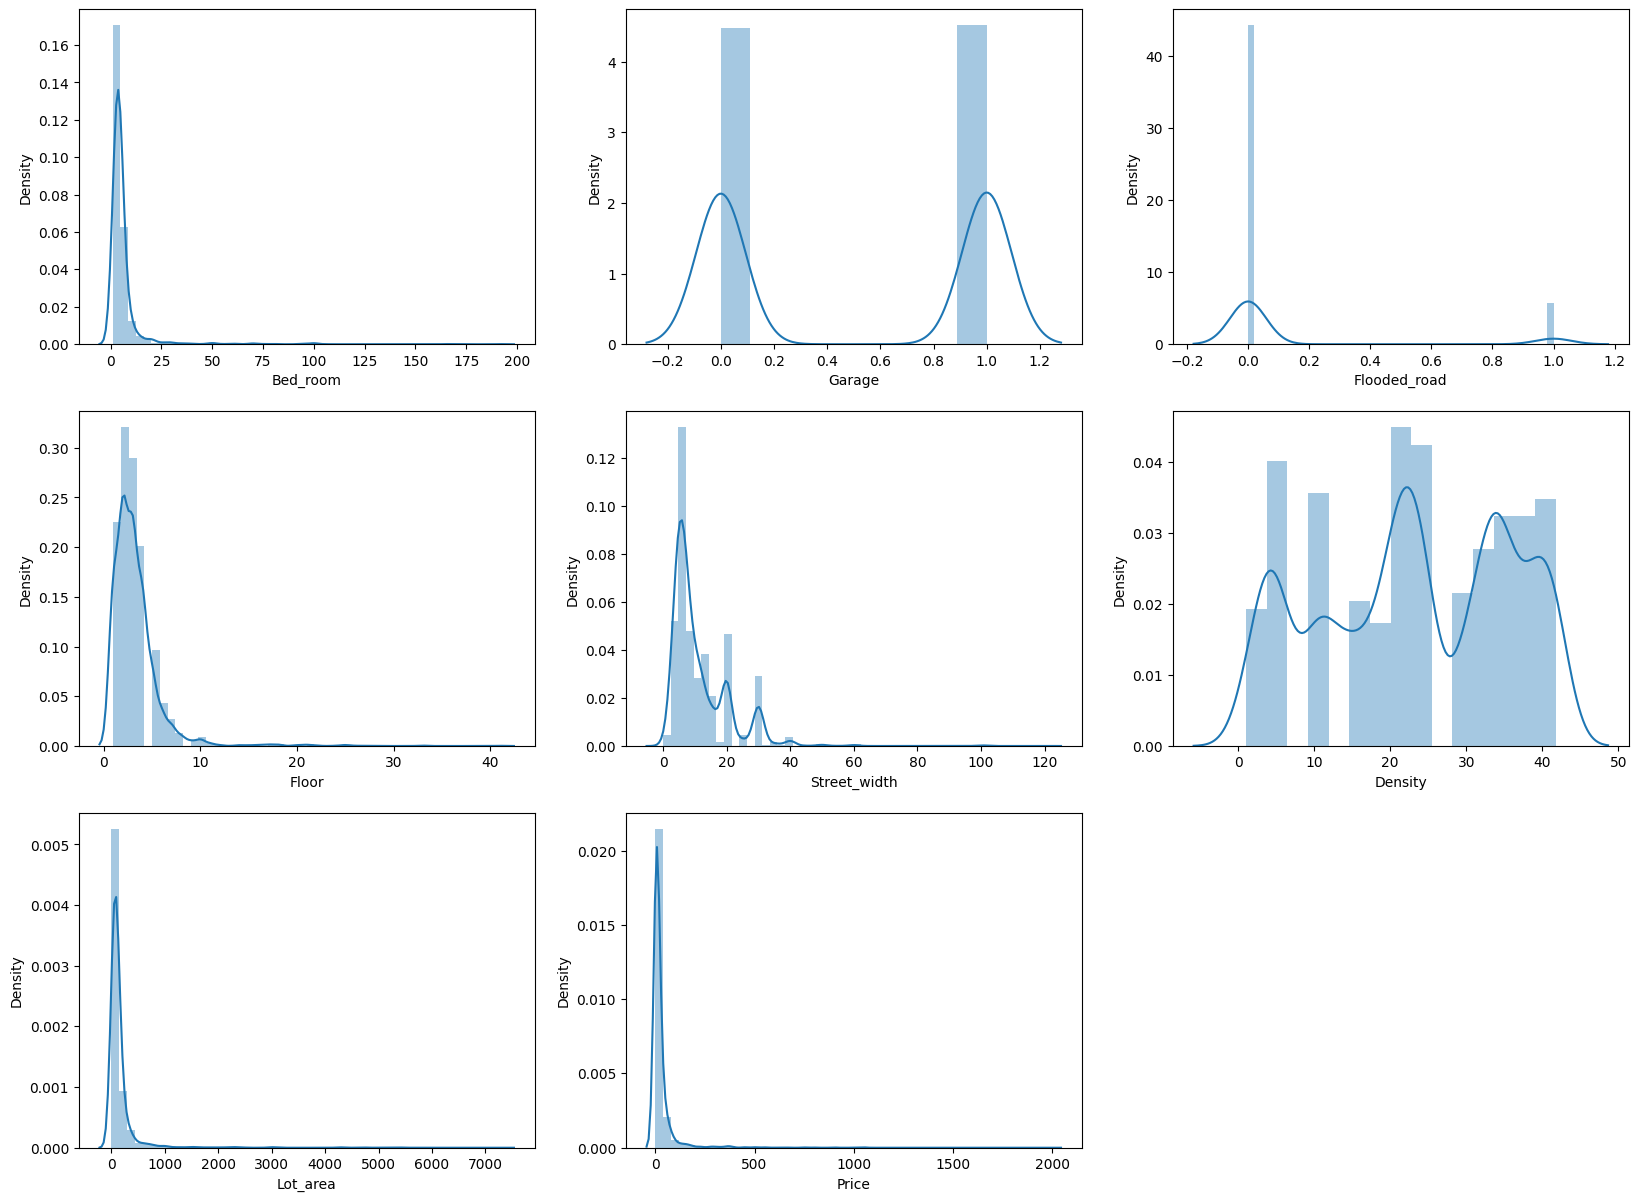

In [ ]:
plt.figure(figsize=(20,20))
def density(list_variables):
  x=1
  for i in list_variables:
    plt.subplot(4,3,x)
    sns.distplot(df1[i])
    x+=1
  plt.savefig('outlier_detection(1).png')

density(list(df1[numerical_features]))

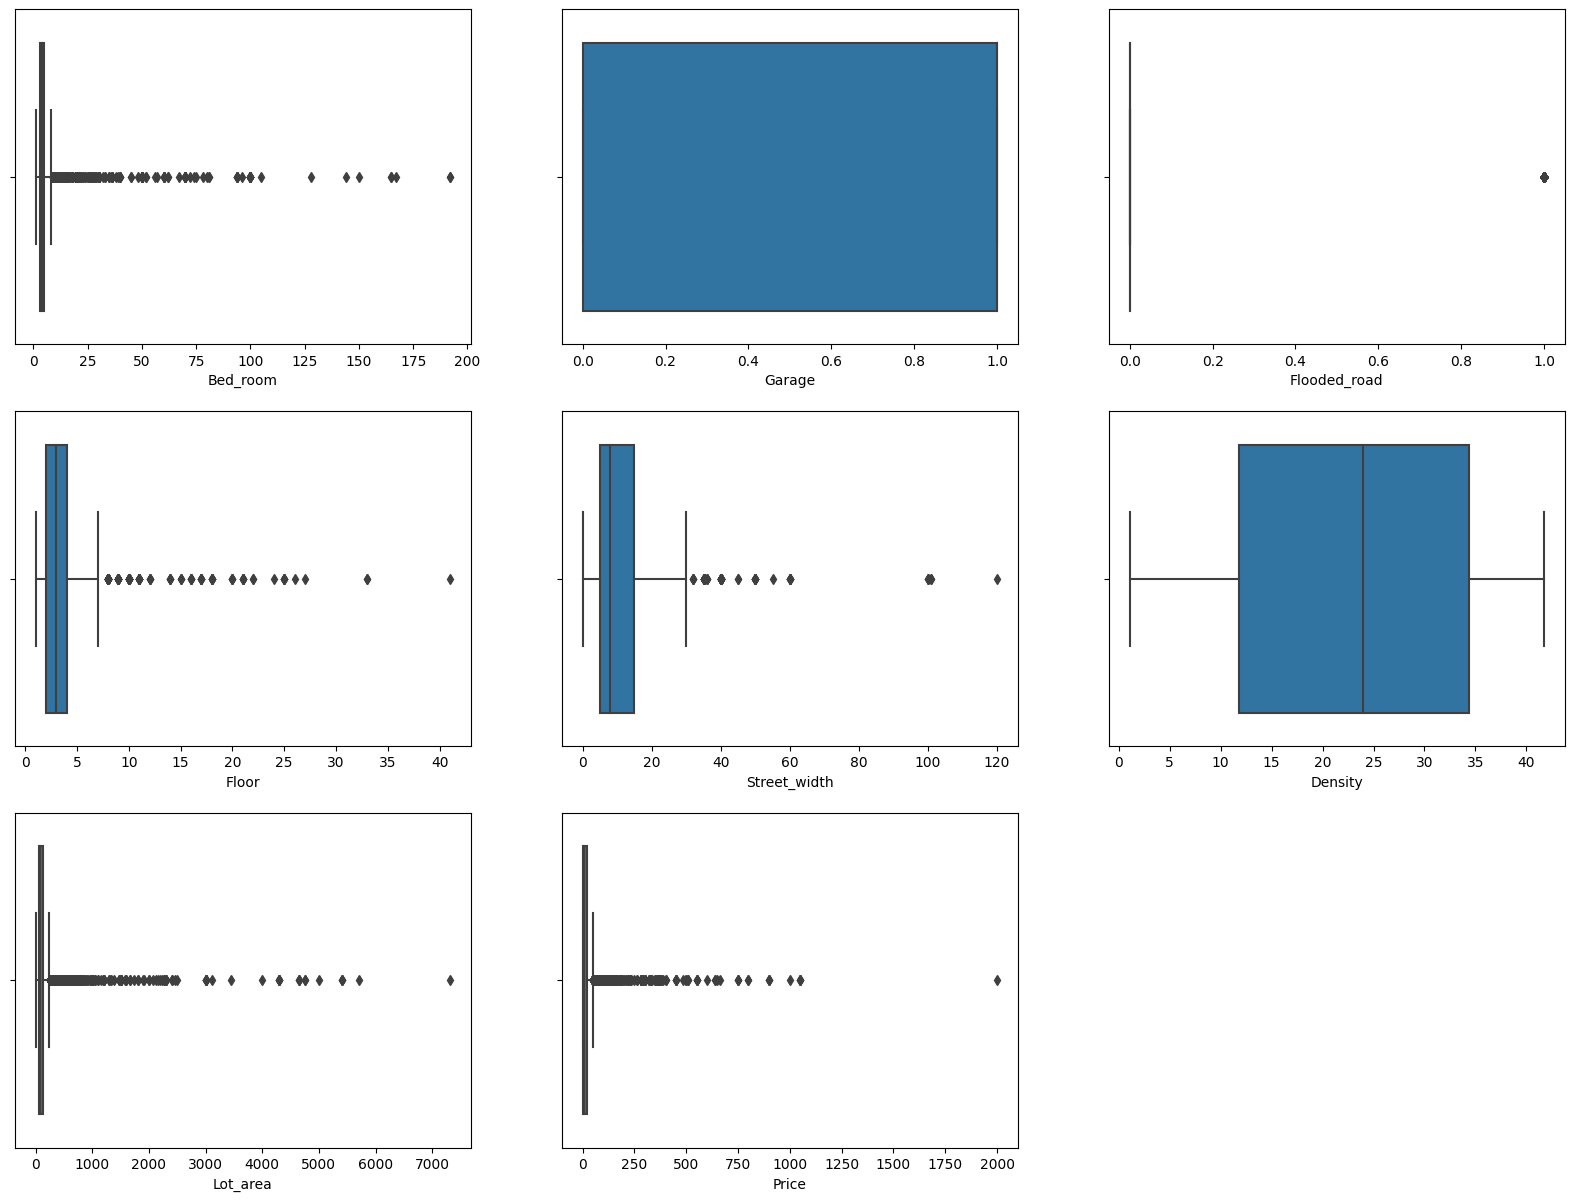

In [ ]:
plt.figure(figsize=(20,20))
def density(list_variables):
  x=1
  for i in list_variables:
    plt.subplot(4,3,x)
    sns.boxplot(x=df1[i])

    x+=1
  plt.savefig('outlier_detection(2).png')

density(list(df1[numerical_features]))

In [ ]:
df1.describe()

Lot_area  Street_width     Bed_room       Garage        Floor  \
count  4458.000000   4458.000000  4458.000000  4458.000000  4458.000000   
mean    165.056528     11.453567     6.129879     0.501795     3.240691   
std     390.977714      9.259344    11.539514     0.500053     2.573084   
min       1.000000      0.000000     1.000000     0.000000     1.000000   
25%      60.000000      5.000000     3.000000     0.000000     2.000000   
50%      80.000000      8.000000     4.000000     1.000000     3.000000   
75%     135.000000     15.000000     5.000000     1.000000     4.000000   
max    7314.000000    120.000000   192.000000     1.000000    41.000000   

             Price  Flooded_road      Density  
count  4458.000000   4458.000000  4458.000000  
mean     27.586608      0.115074    23.261771  
std      78.871401      0.319147    12.345034  
min       0.000000      0.000000     1.063000  
25%       4.000000      0.000000    11.745000  
50%       8.200000      0.000000    23.998000  
75%      22.000000      0.000000    34.360000  
max    2000.000000      1.000000    41.745000

In [ ]:
df1.drop(df1[df1['Bed_room'] > 9].index,inplace=True)
df1.drop(df1[df1['Street_width'] > 20].index,inplace=True)
df1.drop(df1[df1['Price'] > 30].index,inplace=True)
df1.drop(df1[df1['Price'] == 0.0].index,inplace=True)
df1.drop(df1[df1['Price'] < 1.0].index,inplace=True)
df1.drop(df1[df1['Floor'] > 7].index,inplace=True)
df1.drop(df1[df1['Lot_area'] > 200].index,inplace=True)
df1.drop(df1[df1['Lot_area'] <10].index,inplace=True)
df1.drop(df1[df1['Street_width'] == 0].index,inplace=True)

In [ ]:
df1.shape

(3033, 10)

Density of variables after droping outliers

<ipython-input-55-590612a0cad2>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1[i])
<ipython-input-55-590612a0cad2>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1[i])
<ipython-input-55-590612a0cad2>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v

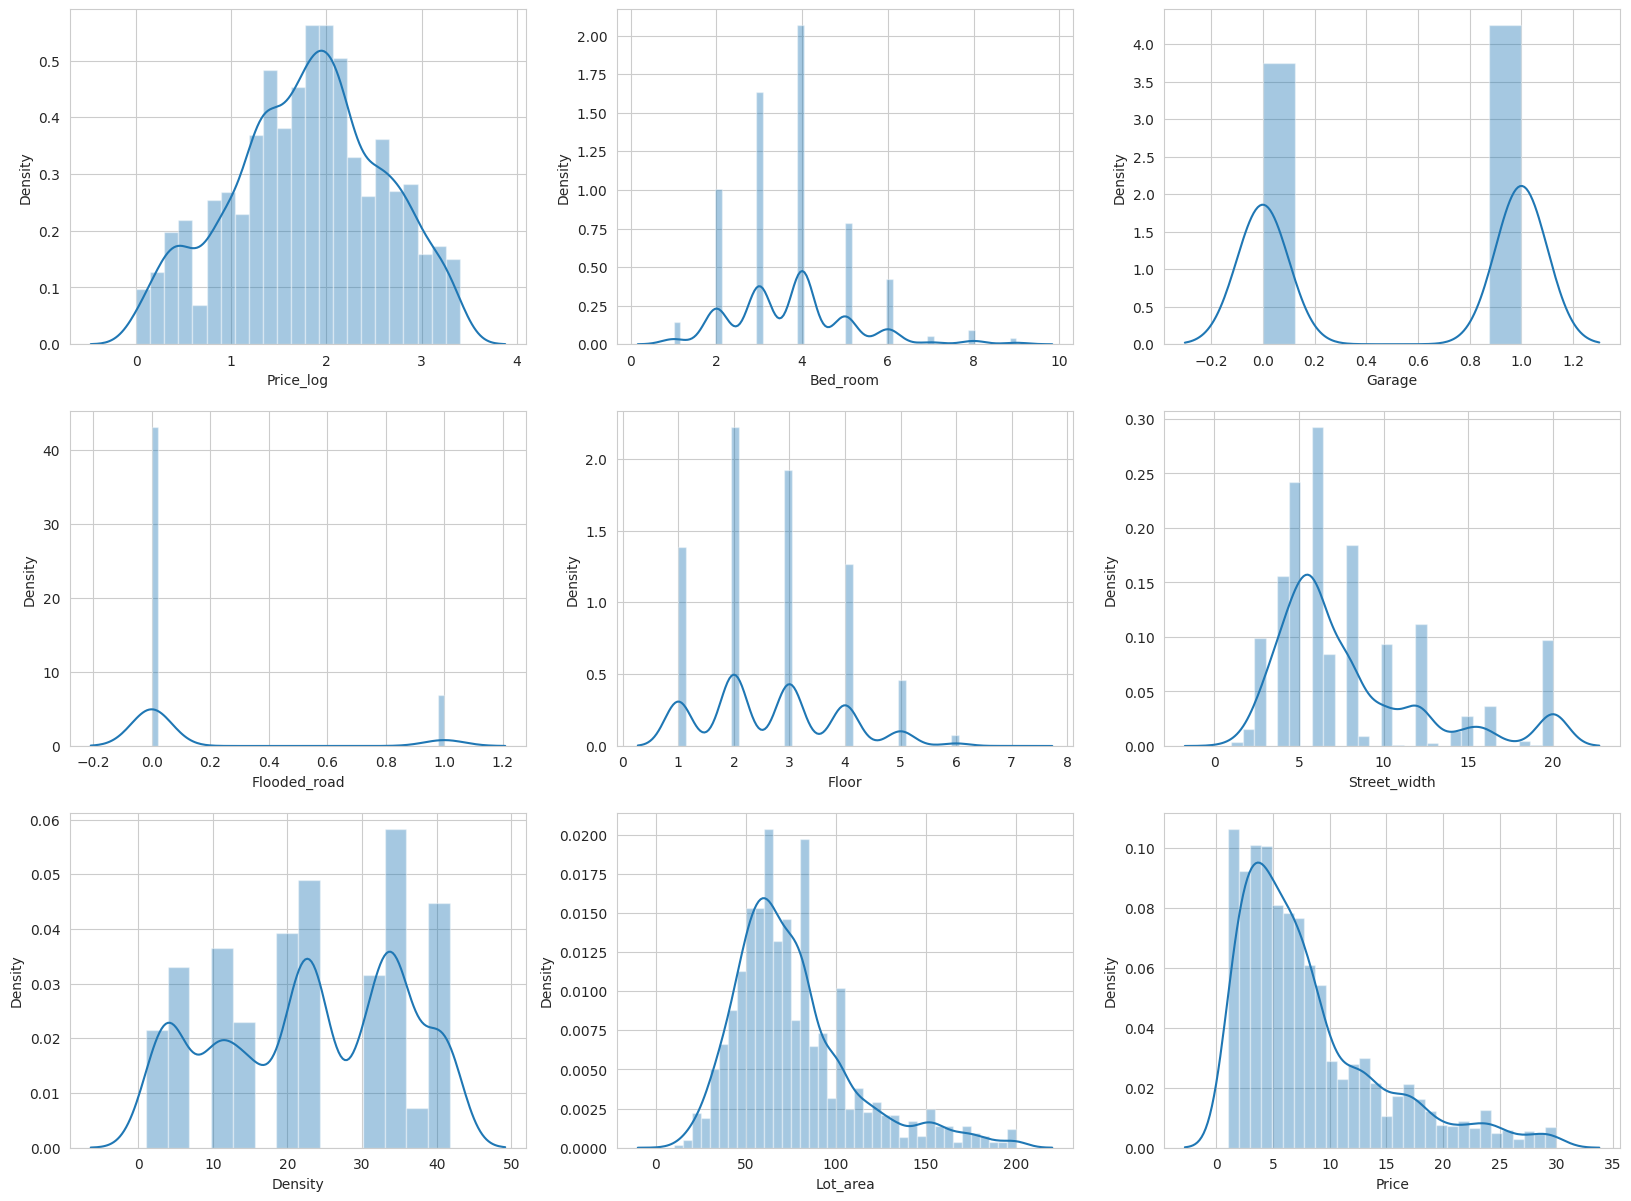

In [ ]:
plt.figure(figsize=(20,20))
def density(list_variables):
  x=1
  for i in list_variables:
    plt.subplot(4,3,x)
    sns.distplot(df1[i])
    x+=1
  plt.savefig('outlier_detection(2).png')

density(list(df1[numerical_features]))

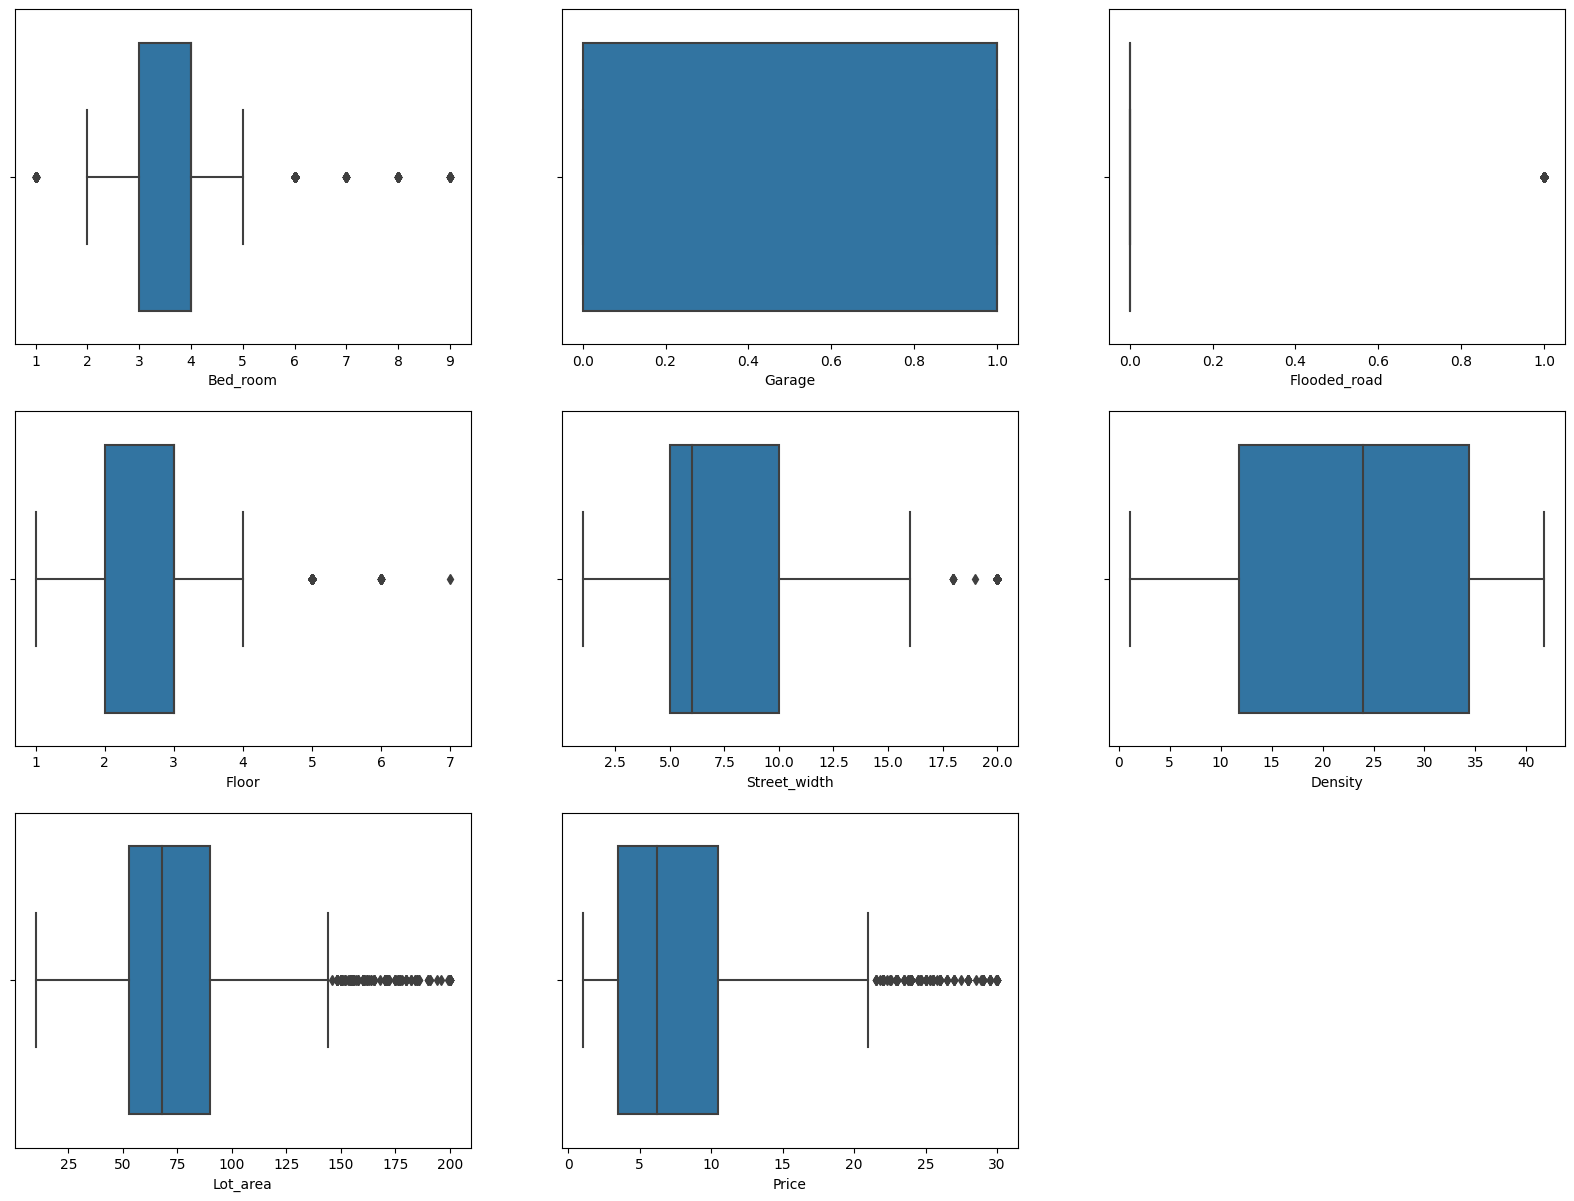

In [ ]:
plt.figure(figsize=(20,20))
def density(list_variables):
  x=1
  for i in list_variables:
    plt.subplot(4,3,x)
    sns.boxplot(x=df1[i])

    x+=1
  plt.savefig('outlier_detection(2).png')

density(list(df1[numerical_features]))

Distribution of flooded roads in HCM

In [ ]:
# Quận nào có nhiều nhà nằm trên đường ngập đang được rao bán nhất?
print(df1[df1['Flooded_road']==1]['District_name'].value_counts())

# Quận nào có nhiều con đường ngập nhất
print(flooded_streets['district'].value_counts())

Huyện Nhà Bè         110
Quận Gò Vấp           83
Quận 7                67
Quận Bình Thạnh       61
Quận Tân Bình         27
Quận Tân Phú          18
Quận Bình Tân         11
Quận 12               10
Thành phố Thủ Đức      7
Quận 4                 7
Quận 5                 6
Quận 6                 3
Quận 11                3
Quận 1                 3
Quận 8                 2
Name: District_name, dtype: int64
Quận 11              8
Thành phố Thủ Đức    8
Quận 6               7
Quận Tân Bình        7
Quận 5               6
Quận Tân Phú         5
Quận 2               4
Quận Bình Thạnh      4
Quận 1               4
Quận 8               4
Quận 9               3
Quận 12              3
Quận 4               3
Quận Gò Vấp          2
Quận 10              1
Quận 7               1
Quận Bình Tân        1
Quận 3               1
Huyện Bình Chánh     1
Huyện Nhà Bè         1
Name: district, dtype: int64


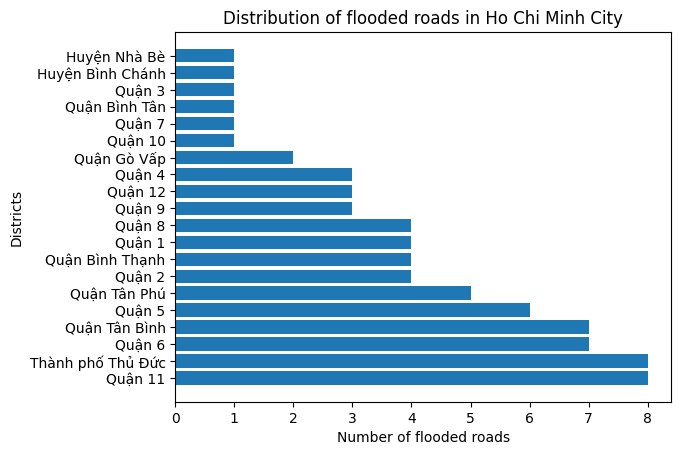

In [ ]:
dt = flooded_streets['district'].value_counts()
x = dt.values
y = dt.index

plt.barh(y, x)

plt.ylabel("Districts")

plt.xlabel("Number of flooded roads")
plt.title("Distribution of flooded roads in Ho Chi Minh City")
plt.show()

Create price log variable in order to balance distribution of price feature

<ipython-input-41-bea0f34dd98d>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x)


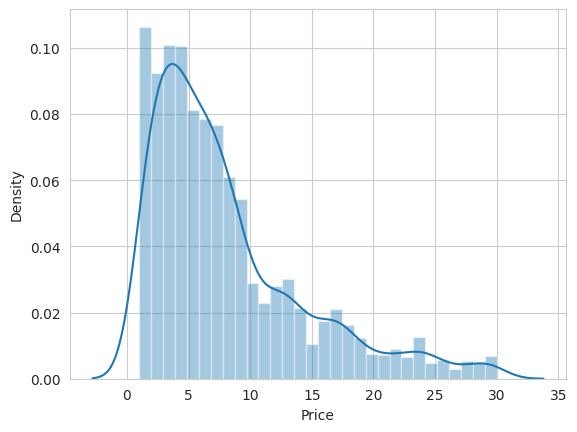

<ipython-input-41-bea0f34dd98d>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x)


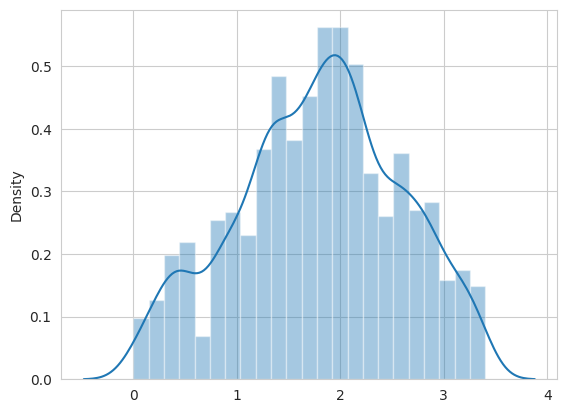

In [ ]:
x = df1.Price
sns.set_style('whitegrid')
sns.distplot(x)
plt.show()

df1['Price_log'] = np.log(df1.Price)
x = list(df1.Price_log)
sns.distplot(x)
plt.show()

**11. Step 11**: Encoding (mã hóa) dataset

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3033 entries, 0 to 4456
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Street_name    3033 non-null   object 
 1   District_name  3033 non-null   object 
 2   Lot_area       3033 non-null   int64  
 3   Street_width   3033 non-null   int64  
 4   Bed_room       3033 non-null   int64  
 5   Garage         3033 non-null   int64  
 6   Floor          3033 non-null   int64  
 7   Price          3033 non-null   float64
 8   Flooded_road   3033 non-null   int64  
 9   Density        3033 non-null   float64
 10  Price_log      3033 non-null   float64
dtypes: float64(3), int64(6), object(2)
memory usage: 284.3+ KB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Encode categorical data to binary: Mã hóa các biến categorical để chạy ma trận tương quan.
from copy import deepcopy
df2 = deepcopy(df1)

for i in range(len(categorical_features)):
  re_value = df2[categorical_features[i]].value_counts().reset_index()
  re_value['new_value'] = re_value.index
  # if i == 0:
  #   re_value.to_excel(r'drive/MyDrive/Do an cuoi ky/street_name_table.xlsx', index=False)
  # else:
  #   re_value.to_excel(r'drive/MyDrive/Do an cuoi ky/district_name_table.xlsx', index=False)
  for j in range(len(re_value)):
    df2[categorical_features[i]] = df2[categorical_features[i]].replace(re_value['index'][j], re_value['new_value'][j])

**Data Description**

In [ ]:
numerical_features=list(set(df2.columns)-set(categorical_features))

In [ ]:
df2[numerical_features].describe()

Price_log     Bed_room       Garage  Flooded_road        Floor  \
count  3033.000000  3033.000000  3033.000000   3033.000000  3033.000000   
mean      1.792925     3.725684     0.531487      0.137817     2.651500   
std       0.792026     1.383536     0.499090      0.344765     1.208839   
min       0.000000     1.000000     0.000000      0.000000     1.000000   
25%       1.252763     3.000000     0.000000      0.000000     2.000000   
50%       1.824549     4.000000     1.000000      0.000000     3.000000   
75%       2.351375     4.000000     1.000000      0.000000     3.000000   
max       3.401197     9.000000     1.000000      1.000000     7.000000   

       Street_width      Density     Lot_area        Price  
count   3033.000000  3033.000000  3033.000000  3033.000000  
mean       7.870755    23.153028    75.465875     8.058391  
std        4.514903    12.276751    33.257137     6.280361  
min        1.000000     1.063000    10.000000     1.000000  
25%        5.000000    11.745000    53.000000     3.500000  
50%        6.000000    23.998000    68.000000     6.200000  
75%       10.000000    34.360000    90.000000    10.500000  
max       20.000000    41.745000   200.000000    30.000000

In [ ]:
df2[categorical_features].describe()

Street_name  District_name
count  3033.000000    3033.000000
mean    133.826904       5.743159
std     147.327984       4.967537
min       0.000000       0.000000
25%      22.000000       2.000000
50%      75.000000       5.000000
75%     201.000000       9.000000
max     617.000000      20.000000

In [ ]:
df1[categorical_features].describe()

Street_name    District_name
count                   3033             3033
unique                   618               21
top     Đường Huỳnh Tấn Phát  Quận Bình Thạnh
freq                     177              380

**Data Visualization**

Mean price by district

In [ ]:
dis_name = list(df1['District_name'].unique())
mean_values = []
for i in dis_name:
  mean_price = mean(list(df1[df1['District_name'] == i]['Price']))
  mean_values.append(mean_price)
dt1 = pd.Series(mean_values, index=dis_name)
dis_list = dt1.sort_values()
dis_list

Huyện Củ Chi          1.369231
Huyện Bình Chánh      2.247619
Huyện Hóc Môn         3.061765
Quận Bình Tân         4.454455
Quận 4                4.878846
Quận 8                5.109804
Quận 12               5.202400
Quận Gò Vấp           6.307396
Huyện Nhà Bè          7.319403
Quận Tân Phú          7.956422
Thành phố Thủ Đức     8.372481
Quận Bình Thạnh       8.492105
Quận 5                8.596875
Quận 11               8.681429
Quận 7                8.787310
Quận 3                8.981308
Quận 6                9.565574
Quận Phú Nhuận        9.732955
Quận 1               10.782051
Quận 10              10.837576
Quận Tân Bình        11.631596
dtype: float64

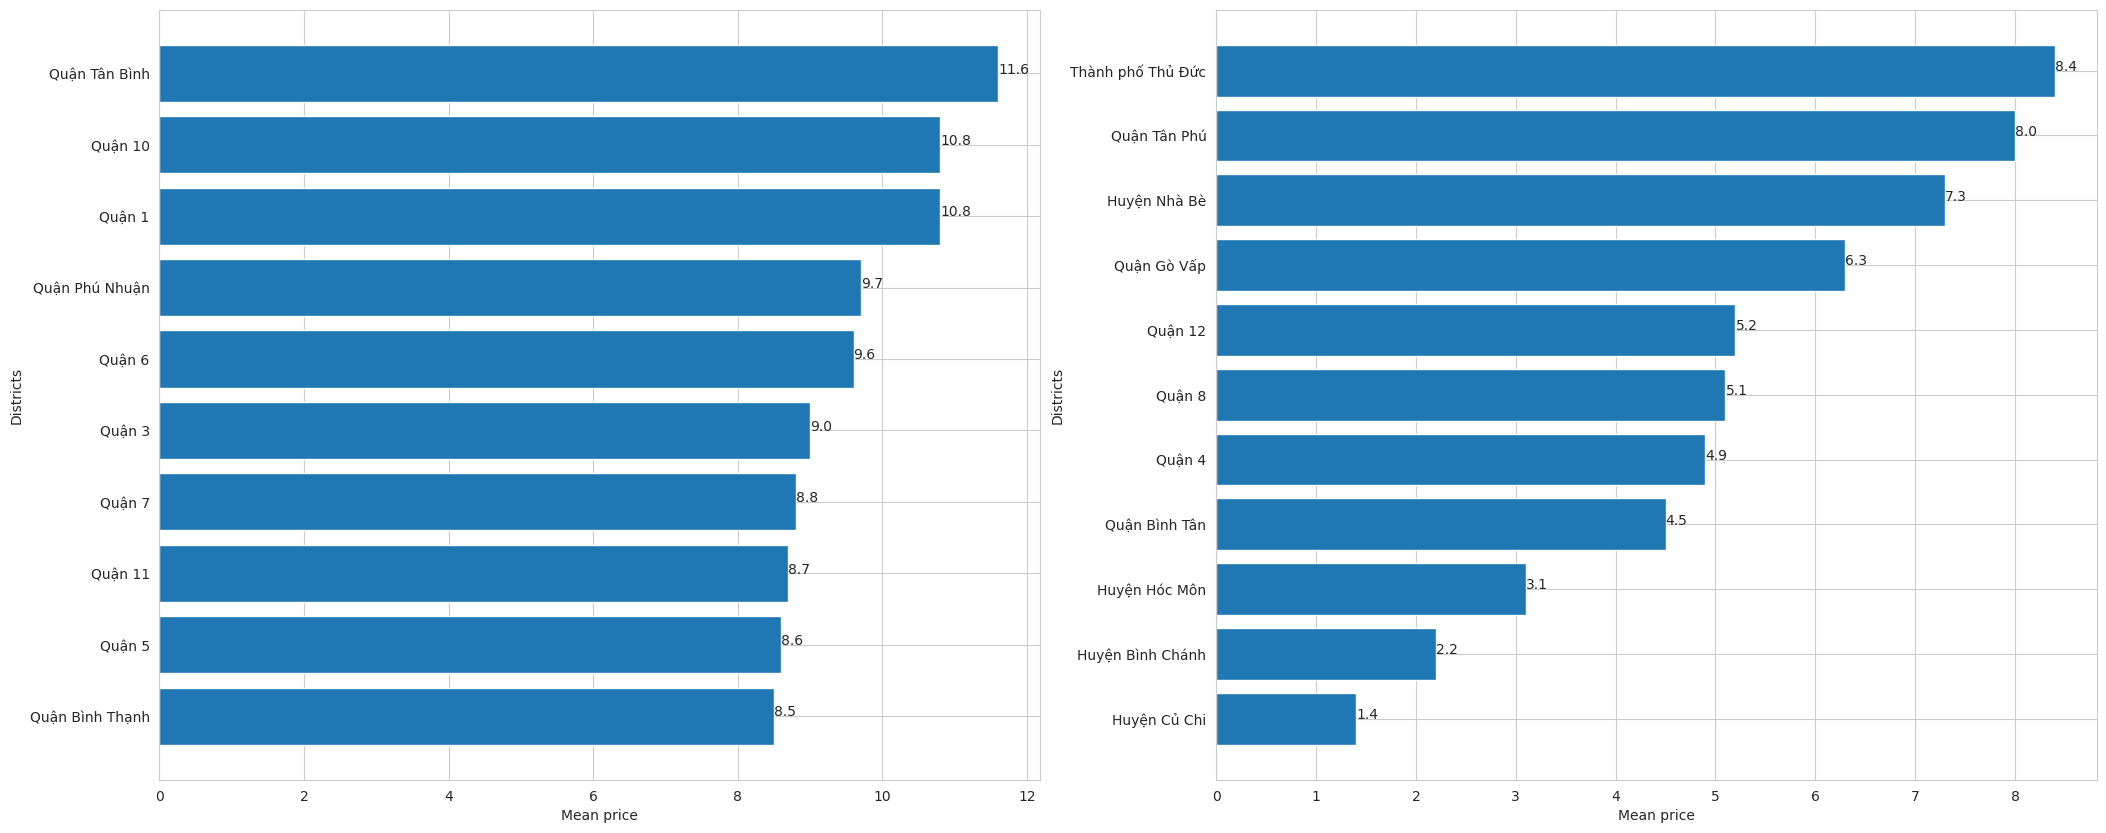

In [ ]:
from statistics import mean
plt.figure(figsize=(25,10))
#plot 1:
x = list(dis_list.index)[0:11]
y = list(dis_list.values)[0:11]
y = [round(num, 1) for num in y]

plt.subplot(1, 2, 2)
plt.barh(x,y)
for index, value in enumerate(y):
    plt.text(value, index,
             str(value))
plt.ylabel("Districts")
plt.xlabel("Mean price")

#plot 2:
x = list(dis_list.index)[11:]
y = list(dis_list.values)[11:]
y = [round(num, 1) for num in y]

plt.subplot(1, 2, 1)
plt.barh(x,y)
for index, value in enumerate(y):
    plt.text(value, index,
             str(value))
plt.ylabel("Districts")
plt.xlabel("Mean price")

#plt.title("Mean price of every district in Ho Chi Minh City")
plt.show()

Mean price per square meter

In [ ]:
ind1 = list(df1.index)
price_per_meter=[]
dis_name = []
for i in ind1:
  value = round(df1.loc[i,'Price'] / df1.loc[i,'Lot_area'] * 1000,1)
  price_per_meter.append(value)
  dis_name.append(df1.loc[i,'District_name'])
dt2 = pd.DataFrame(list(zip(price_per_meter, dis_name)), columns = ['Price_per_meter', 'District_name'], index=ind1)
dt2

Price_per_meter      District_name
0               195.7             Quận 6
1               102.8       Quận Tân Phú
2               153.8       Quận Tân Phú
5               109.1       Huyện Nhà Bè
6               107.1       Huyện Nhà Bè
...               ...                ...
4447            139.0      Quận Tân Bình
4448            188.2  Thành phố Thủ Đức
4449             82.5  Thành phố Thủ Đức
4455            127.8             Quận 6
4456             65.5            Quận 12

[3033 rows x 2 columns]

In [ ]:
dis_name = list(dt2['District_name'].unique())
mean_values = []
for i in dis_name:
  mean_price = mean(list(dt2[dt2['District_name'] == i]['Price_per_meter']))
  mean_values.append(mean_price)
dt3 = pd.Series(mean_values, index=dis_name)
dis_list = dt3.sort_values()
dis_list

Huyện Củ Chi          16.807692
Huyện Bình Chánh      21.297619
Huyện Hóc Môn         30.055882
Quận 12               67.789600
Quận 8                68.962745
Quận Bình Tân         75.275248
Quận Gò Vấp           88.320118
Thành phố Thủ Đức     90.417054
Huyện Nhà Bè          95.197761
Quận 7               103.863452
Quận Tân Phú         105.626606
Quận Bình Thạnh      112.057105
Quận 4               117.084615
Quận 3               128.828037
Quận 5               128.982812
Quận 6               131.413115
Quận 11              133.925714
Quận Tân Bình        138.728990
Quận Phú Nhuận       146.753409
Quận 10              166.209697
Quận 1               188.853846
dtype: float64

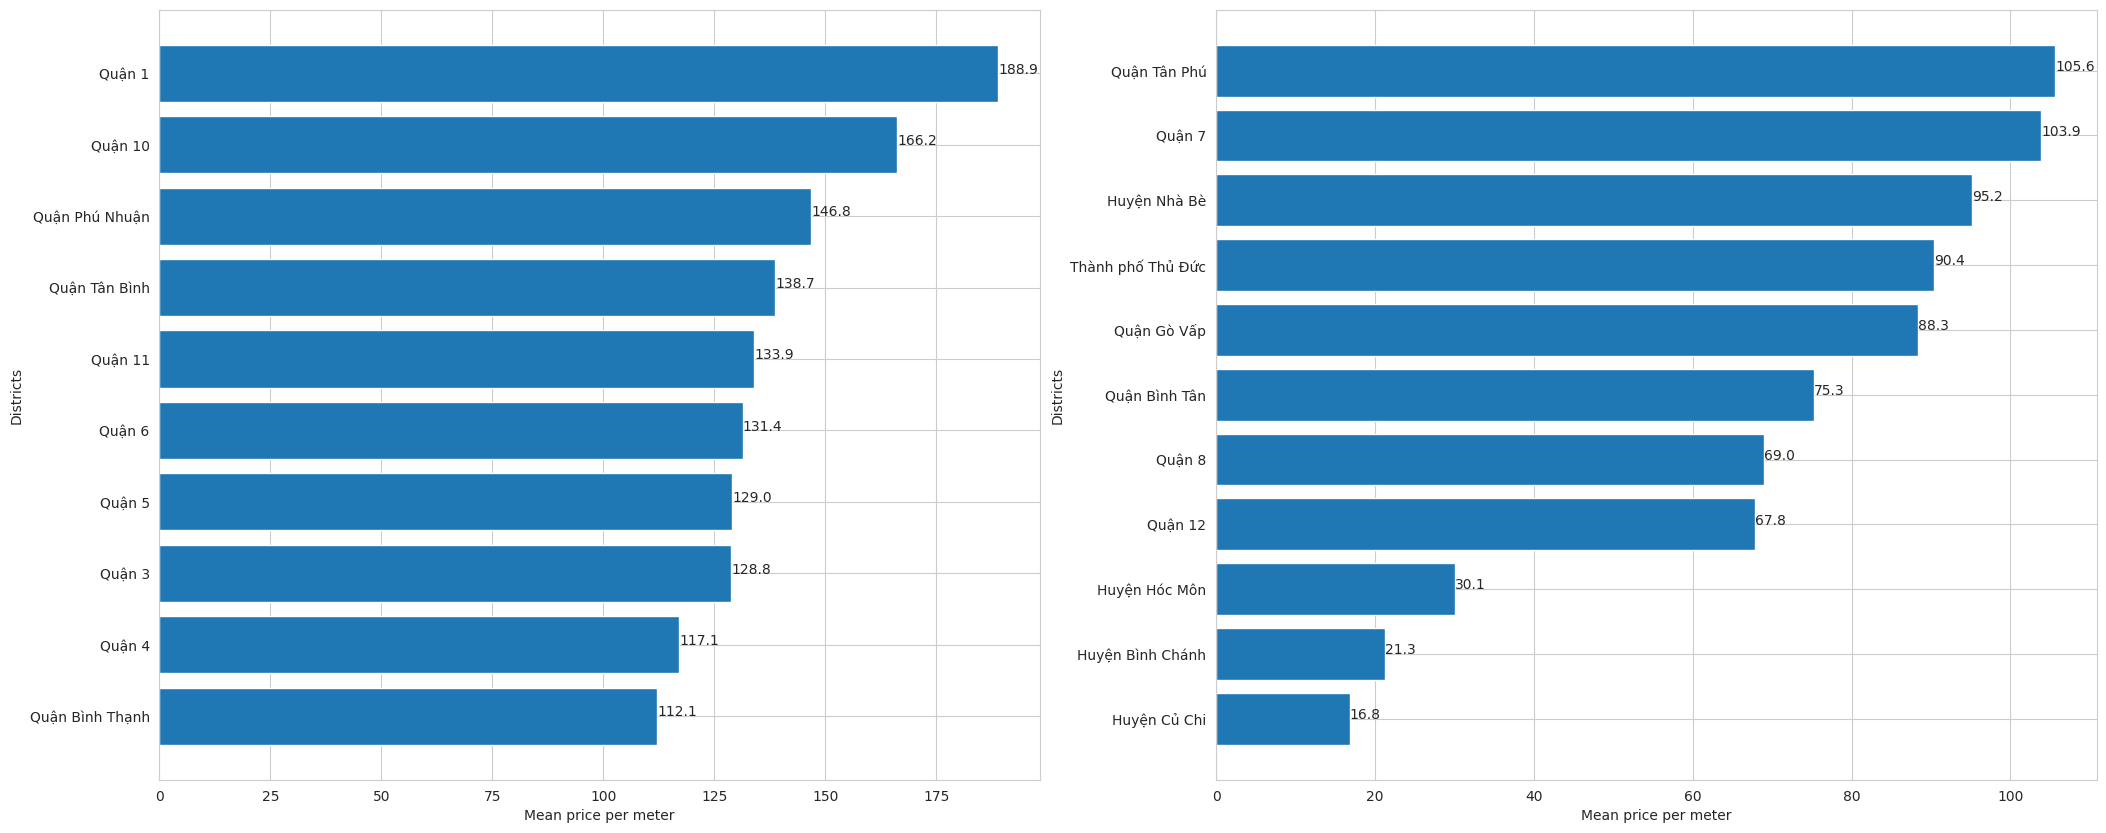

In [ ]:
from statistics import mean
plt.figure(figsize=(25,10))
#plot 1:
x = list(dis_list.index)[0:11]
y = list(dis_list.values)[0:11]
y = [round(num, 1) for num in y]

plt.subplot(1, 2, 2)
plt.barh(x,y)
for index, value in enumerate(y):
    plt.text(value, index,
             str(value))
plt.ylabel("Districts")
plt.xlabel("Mean price per meter")

#plot 2:
x = list(dis_list.index)[11:]
y = list(dis_list.values)[11:]
y = [round(num, 1) for num in y]

plt.subplot(1, 2, 1)
plt.barh(x,y)
for index, value in enumerate(y):
    plt.text(value, index,
             str(value))
plt.ylabel("Districts")
plt.xlabel("Mean price per meter")

#plt.title("Mean price per meter of every district in Ho Chi Minh City")
plt.show()

Scatter plots for the correlation between all independent variables and target variable

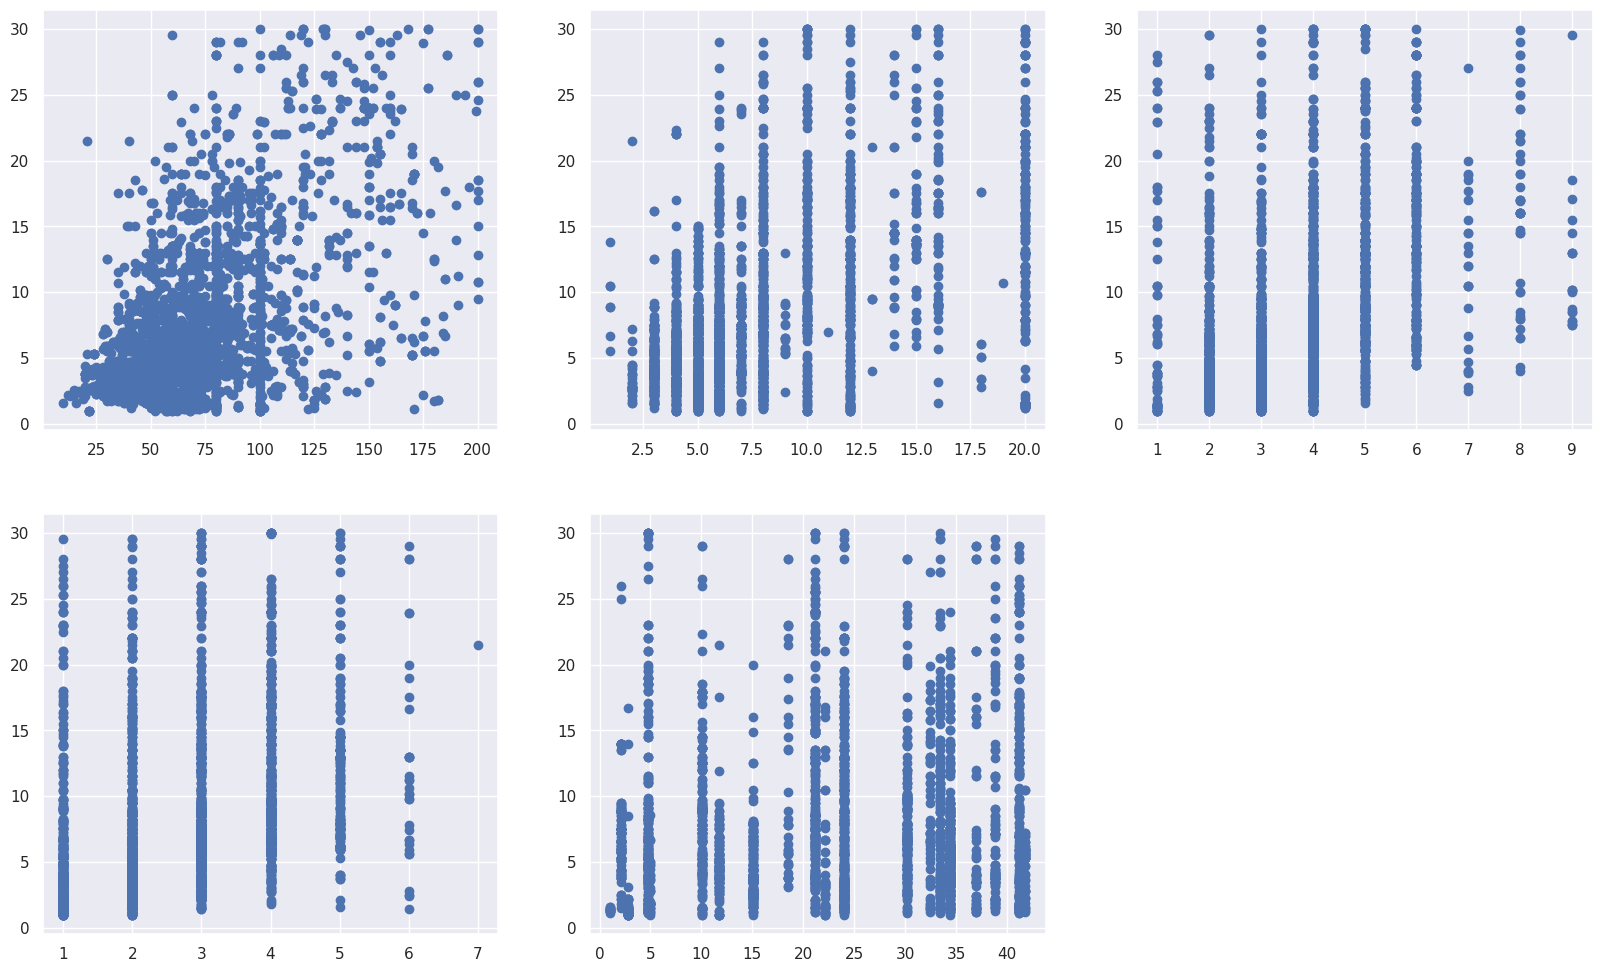

In [ ]:
# Histogram of numerical features

plt.figure(figsize=(20,12))
def chart_hist(variables):
  x=1
  for i in variables:
    plt.subplot(2,3,x)
    plt.scatter(list(df2[i]), list(df2.Price))
    x+=1
  plt.show()
chart_hist(['Lot_area', 'Street_width', 'Bed_room', 'Floor', 'Density'])

3D plot for correlation between 3 variables

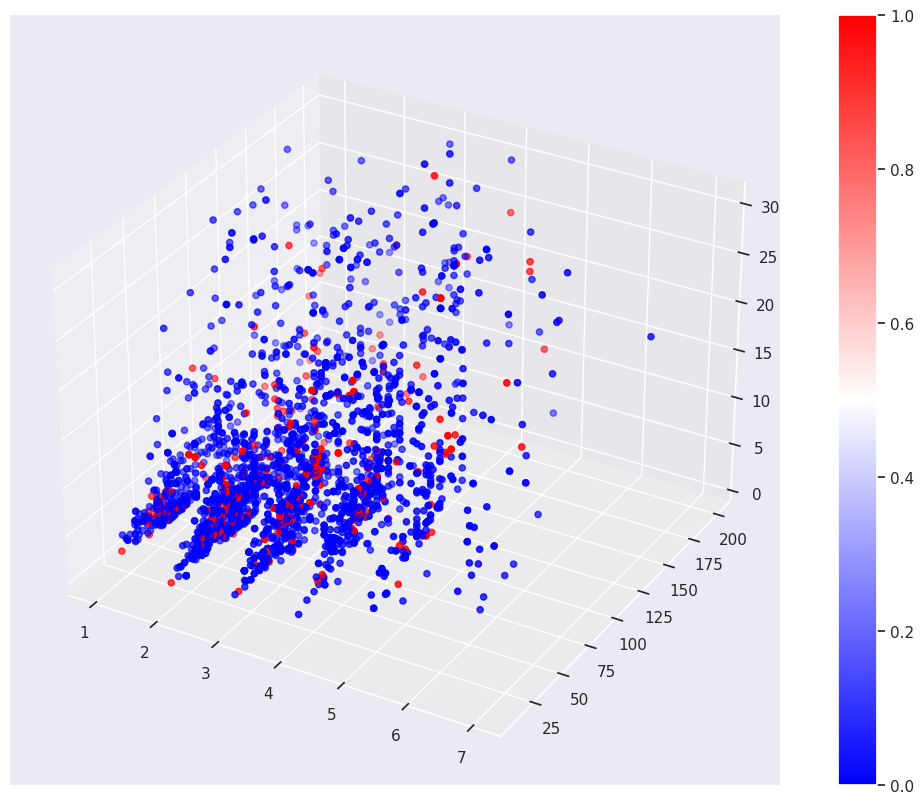

In [ ]:
# 3D scatter plot

fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection='3d')
plt_3d = ax.scatter3D(list(df2["Floor"]), list(df2["Lot_area"]), list(df2["Price"]), marker='o', c=list(df2['Flooded_road']), cmap='bwr')
plt.colorbar(plt_3d)
plt.show()

Distribution of price per unique value in variables

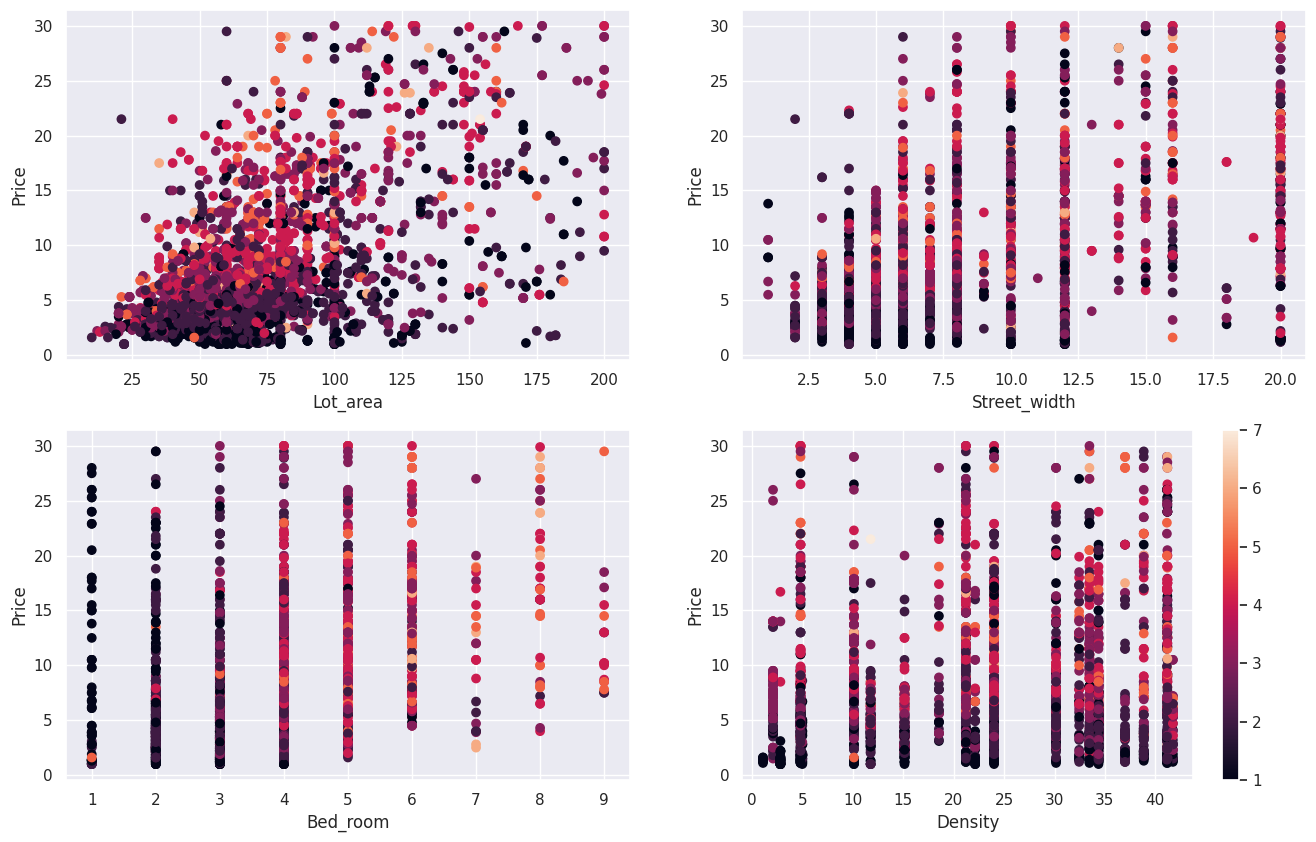

In [ ]:
# Scatter plots of numerical features

plt.figure(figsize=(16,10))
def chart_hist(variables):
  x=1
  for i in variables:
    plt.subplot(2,2,x)
    plt.scatter(list(df2[i]), list(df2.Price), c=df2['Floor'])
    plt.xlabel(f'{i}')
    plt.ylabel('Price')
    x+=1
  plt.colorbar()
  plt.show()
chart_hist(['Lot_area', 'Street_width', 'Bed_room', 'Density'])

In [ ]:
# Number of bedrooms


In [ ]:
# Garage


In [ ]:
# Flooded roads


Correlation matrix

In [ ]:
price_log = list(df2.Price_log)
df2.drop('Price_log', axis=1, inplace=True)
df2['Price_log'] = price_log

In [ ]:
df2

Street_name  District_name  Lot_area  Street_width  Bed_room  Garage  \
0             372             14        92            20         4       1   
1             104              4        36             7         2       0   
2             286              4        78             8         3       1   
5               0              9        55             6         4       0   
6               0              9        70             9         5       1   
...           ...            ...       ...           ...       ...     ...   
4447            8              2        59             5         3       0   
4448          400              3        85            20         4       1   
4449          223              3        57             4         3       0   
4455          164             14        90             7         2       1   
4456          389             10        58             5         2       0   

      Floor  Price  Flooded_road  Density  Price_log  
0         4   18.0             0   32.439   2.890372  
1         2    3.7             0   30.146   1.308333  
2         3   12.0             0   30.146   2.484907  
5         3    6.0             1    2.060   1.791759  
6         4    7.5             1    2.060   2.014903  
...     ...    ...           ...      ...        ...  
4447      2    8.2             0   21.196   2.104134  
4448      4   16.0             0    4.791   2.772589  
4449      1    4.7             0    4.791   1.547563  
4455      1   11.5             0   32.439   2.442347  
4456      2    3.8             0   11.745   1.335001  

[3033 rows x 11 columns]

In [ ]:
corr_df=df2.corr()
corr_df

Street_name  District_name  Lot_area  Street_width  Bed_room  \
Street_name       1.000000       0.219104 -0.006241      0.039468 -0.033772   
District_name     0.219104       1.000000 -0.031813      0.049298 -0.062850   
Lot_area         -0.006241      -0.031813  1.000000      0.346463  0.279548   
Street_width      0.039468       0.049298  0.346463      1.000000  0.219566   
Bed_room         -0.033772      -0.062850  0.279548      0.219566  1.000000   
Garage           -0.015937      -0.025671  0.148770      0.118461  0.165358   
Floor            -0.068118      -0.116575  0.057521      0.208447  0.618633   
Price            -0.003562      -0.089827  0.525162      0.526968  0.429578   
Flooded_road     -0.239034      -0.053275  0.009903     -0.068010 -0.011987   
Density          -0.039877      -0.004648 -0.184689     -0.014465  0.077637   
Price_log        -0.014706      -0.151275  0.445675      0.440631  0.466039   

                 Garage     Floor     Price  Flooded_road   Density  Price_log  
Street_name   -0.015937 -0.068118 -0.003562     -0.239034 -0.039877  -0.014706  
District_name -0.025671 -0.116575 -0.089827     -0.053275 -0.004648  -0.151275  
Lot_area       0.148770  0.057521  0.525162      0.009903 -0.184689   0.445675  
Street_width   0.118461  0.208447  0.526968     -0.068010 -0.014465   0.440631  
Bed_room       0.165358  0.618633  0.429578     -0.011987  0.077637   0.466039  
Garage         1.000000  0.151854  0.090320      0.085945 -0.109701   0.144135  
Floor          0.151854  1.000000  0.398688     -0.002633  0.069270   0.499342  
Price          0.090320  0.398688  1.000000     -0.036300  0.091563   0.910568  
Flooded_road   0.085945 -0.002633 -0.036300      1.000000 -0.170873   0.007872  
Density       -0.109701  0.069270  0.091563     -0.170873  1.000000   0.085227  
Price_log      0.144135  0.499342  0.910568      0.007872  0.085227   1.000000

In [ ]:
# Tải file excel kết quả về gdrive
corr_df.to_excel(r'drive/MyDrive/Do an cuoi ky/variable_correlation.xlsx', index=False)

<ipython-input-61-b7530eb6e2b4>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_mat, dtype=np.bool)


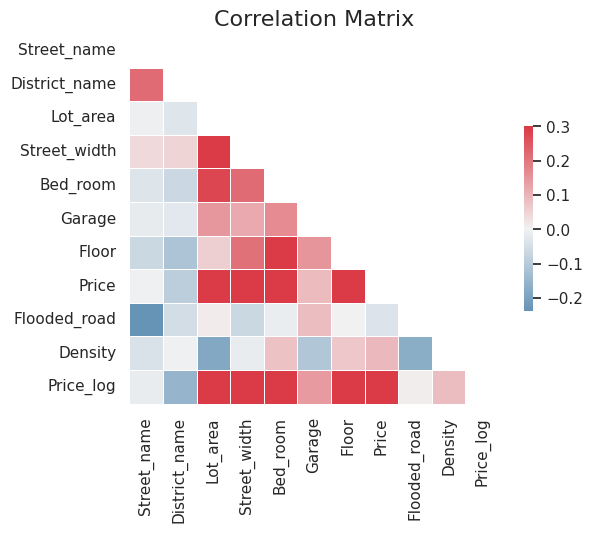

In [ ]:
def plot_correlation_matrix(corr_mat):
 sns.set(style="white")
 mask = np.zeros_like(corr_mat, dtype=np.bool)
 mask[np.triu_indices_from(mask)] = True
 fig, ax = plt.subplots()
 cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
 sns.heatmap(corr_mat, mask=mask, cmap=cmap, vmax=.3, center=0,
 square=True, linewidths=.5,
 cbar_kws={"shrink": .5}, ax=ax)
 ax.set_title('Correlation Matrix', fontsize=16)
 sns.set(style="darkgrid")
corr_mat = df2.select_dtypes(include='number').corr()
plot_correlation_matrix(df2.corr())

Feature importance correlation

In [ ]:
column_selected = [x for x in df2.columns if (x != 'Price_log')]
correlation = df2.corr().iloc[:-1,-1].values

features_importances_corr = pd.DataFrame({'FeatureName': df2[column_selected].columns[0:len(df2[column_selected])-1], 'Pearson Correlation with target': correlation})
features_importances_corr.reindex(features_importances_corr['Pearson Correlation with target'].abs().sort_values(ascending=False).index)

FeatureName  Pearson Correlation with target
7          Price                         0.910568
6          Floor                         0.499342
4       Bed_room                         0.466039
2       Lot_area                         0.445675
3   Street_width                         0.440631
1  District_name                        -0.151275
5         Garage                         0.144135
9        Density                         0.085227
0    Street_name                        -0.014706
8   Flooded_road                         0.007872

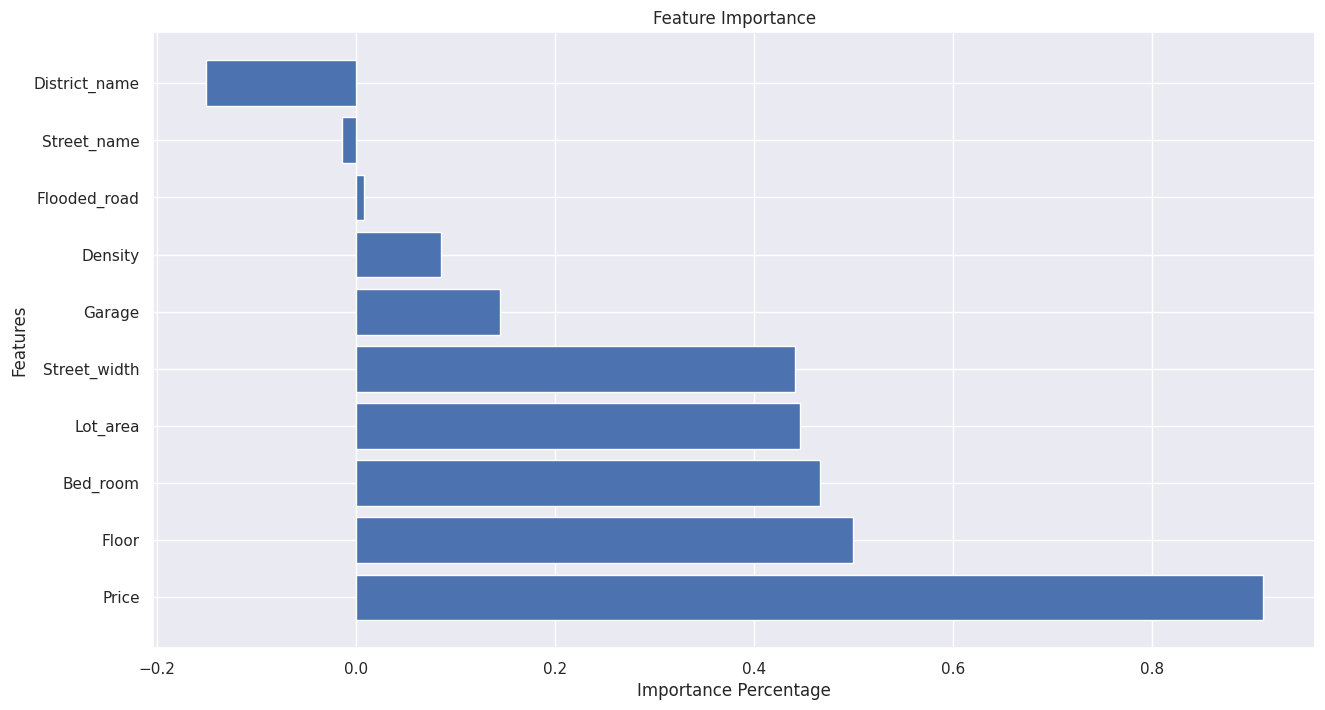

In [ ]:
feature_imp = pd.DataFrame(df2.corr().loc[:,'Price_log']).sort_values(by= ['Price_log'], ascending=False).iloc[1:,:]
plt.figure(figsize=(15,8))
plt.barh(feature_imp.index,feature_imp['Price_log'].values)
plt.title('Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance Percentage')
plt.show()

**Building Model**

**1. Step 1**: Split train, test, and validation sets

In [ ]:
from sklearn import preprocessing
from sklearn import utils

X = df2.drop(columns=['Price','Price_log'])
y = df2.Price_log

# Train-test split
X_train, X_test1, y_train, y_test1 = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=0)
X_test, X_val, y_test, y_val = train_test_split(X_test1, y_test1, train_size=0.67, shuffle=True, random_state=0)

In [ ]:
print(X_train.shape, X_test.shape, X_val.shape)

(2123, 9) (609, 9) (301, 9)


In [ ]:
# Import libraries
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

Multiple variable linear regression

In [ ]:
mlr = LinearRegression()
mlr.fit(X_train,y_train)
mlr_score = mlr.score(X_test,y_test)
pred_mlr = mlr.predict(X_test)
expl_mlr = explained_variance_score(pred_mlr,y_test)

Text(0, 0.5, 'Predicted')

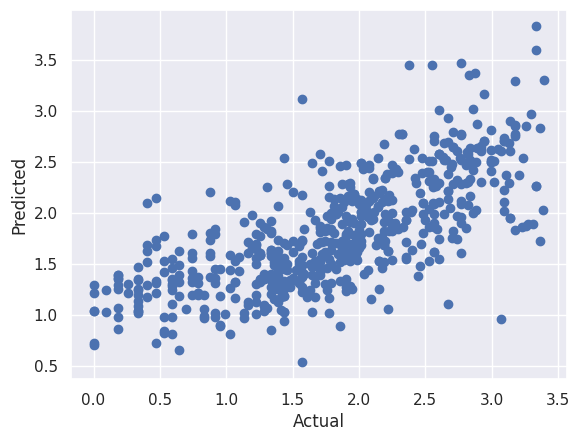

In [ ]:
plt.scatter(y_test,pred_mlr)
plt.xlabel('Actual')
plt.ylabel('Predicted')

<Axes: xlabel='Price_log'>

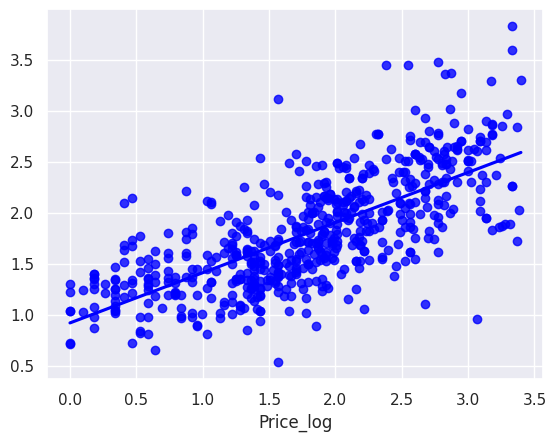

In [ ]:
sns.regplot(x=y_test,y=pred_mlr,ci=None,color ='blue')

Decision tree regression

In [ ]:
tr_regressor = DecisionTreeRegressor(random_state=0)
tr_regressor.fit(X_train,y_train)
pred_tr = tr_regressor.predict(X_test)
decision_score = tr_regressor.score(X_test,y_test)
expl_tr = explained_variance_score(pred_tr,y_test)

Text(0, 0.5, 'Predicted')

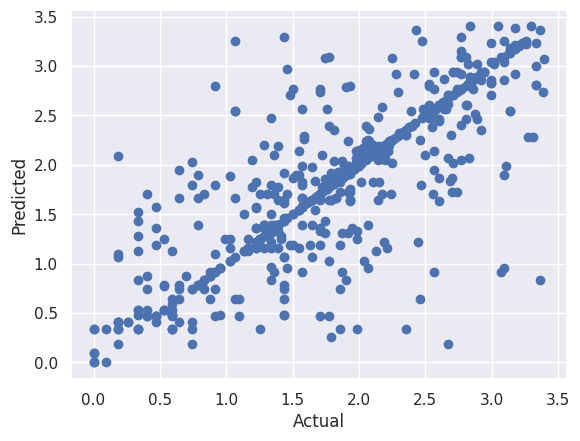

In [ ]:
plt.scatter(y_test,pred_tr)
plt.xlabel('Actual')
plt.ylabel('Predicted')

<Axes: xlabel='Price_log'>

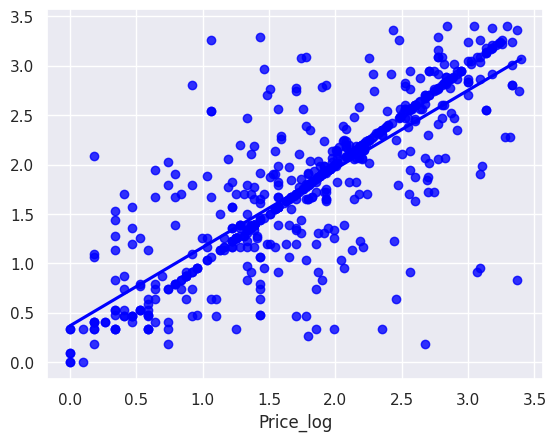

In [ ]:
sns.regplot(x=y_test,y=pred_tr,ci=None,color ='blue')

Random forest regression

In [ ]:
rf_regressor = RandomForestRegressor(n_estimators=100,random_state=0)
rf_regressor.fit(X_train,y_train)
rf_pred =rf_regressor.predict(X_test)
rf_score=rf_regressor.score(X_test,y_test)
expl_rf = explained_variance_score(rf_pred,y_test)

Text(0, 0.5, 'Predicted')

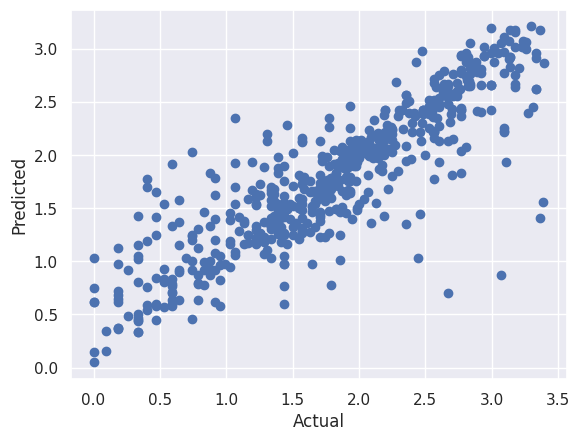

In [ ]:
plt.scatter(y_test,rf_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

<Axes: xlabel='Price_log'>

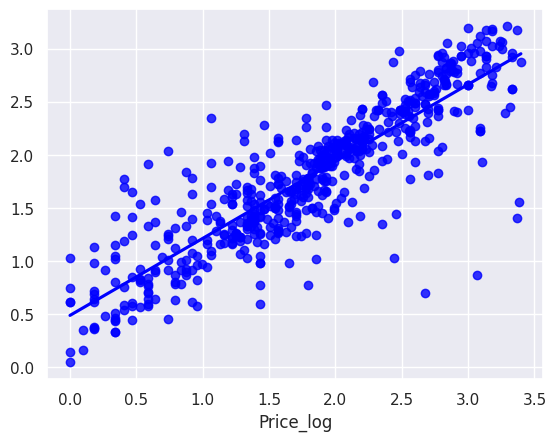

In [ ]:
sns.regplot(x=y_test,y=rf_pred,ci=None,color ='blue')

SVM Regression

In [ ]:
from sklearn import svm
from sklearn.svm import SVC

svm_regressor = svm.SVR()
svm_regressor.fit(X_train,y_train)
svm_pred = svm_regressor.predict(X_test)
svm_score = svm_regressor.score(X_test,y_test)
expl_svm = explained_variance_score(svm_pred,y_test)

Text(0, 0.5, 'Predicted')

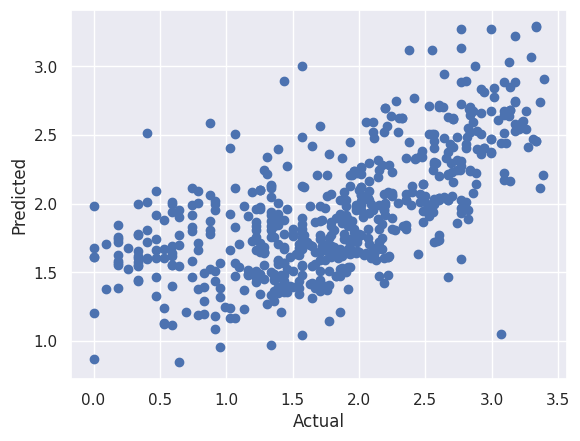

In [ ]:
plt.scatter(y_test,svm_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

<Axes: xlabel='Price_log'>

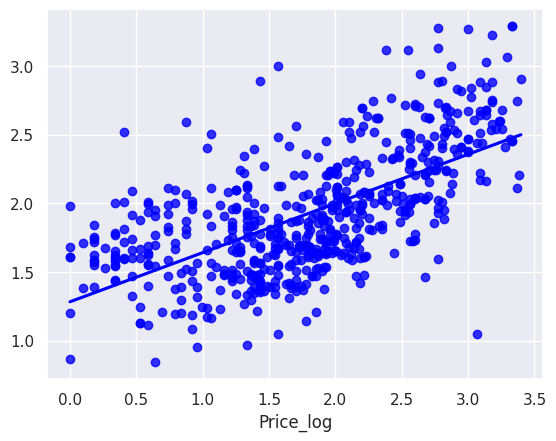

In [ ]:
sns.regplot(x=y_test,y=svm_pred,ci=None,color ='blue')

In [ ]:
#Let's have a tabular pandas data frame, for a clear comparison
from sklearn import metrics

mlr_mae = metrics.mean_absolute_error(y_test, pred_mlr)
mlr_mse = metrics.mean_squared_error(y_test, pred_mlr)
mlr_rmse = np.sqrt(metrics.mean_squared_error(y_test, pred_mlr))

tr_mae = metrics.mean_absolute_error(y_test, pred_tr)
tr_mse = metrics.mean_squared_error(y_test, pred_tr)
tr_rmse = np.sqrt(metrics.mean_squared_error(y_test, pred_tr))

svm_mae = metrics.mean_absolute_error(y_test, svm_pred)
svm_mse = metrics.mean_squared_error(y_test, svm_pred)
svm_rmse = np.sqrt(metrics.mean_squared_error(y_test, svm_pred))

rf_mae = metrics.mean_absolute_error(y_test, rf_pred)
rf_mse = metrics.mean_squared_error(y_test, rf_pred)
rf_rmse = np.sqrt(metrics.mean_squared_error(y_test, rf_pred))

models_score =pd.DataFrame({'Model':['Multiple Linear Regression','Decision Tree', 'SVM Regression', 'Random forest Regression'],
                            'R2_Score':[mlr_score,decision_score, svm_score, rf_score],
                            'Explained Variance Score':[expl_mlr,expl_tr,expl_svm, expl_rf],
                            'MAE': [mlr_mae, tr_mae, svm_mae, rf_mae],
                            'MSE': [mlr_mse, tr_mse, svm_mse, rf_mse],
                            'RMSE': [mlr_rmse, tr_rmse, svm_rmse, rf_rmse]
                           })
models_score
# Source: https://www.kaggle.com/code/subhradeep88/house-price-predict-decision-tree-random-forest

Model  R2_Score  Explained Variance Score       MAE  \
0  Multiple Linear Regression  0.512695                 -0.033475  0.432306   
1               Decision Tree  0.594706                  0.592592  0.280697   
2              SVM Regression  0.380241                 -0.898291  0.475592   
3    Random forest Regression  0.760975                  0.653466  0.252090   

        MSE      RMSE  
0  0.309788  0.556586  
1  0.257652  0.507595  
2  0.393991  0.627687  
3  0.151952  0.389810

In [ ]:
result = pd.DataFrame({'Actual': list(y_test), 'Predicted': rf_pred.flatten(), 'Distance': rf_pred.flatten()-list(y_test)})
print(result.head(20))

      Actual  Predicted  Distance
0   1.974081   2.070321  0.096239
1   1.252763   1.256993  0.004230
2   0.641854   1.369350  0.727496
3   0.916291   1.785958  0.869667
4   1.335001   1.698961  0.363960
5   1.458615   1.162777 -0.295838
6   1.589235   1.797623  0.208388
7   1.568616   1.726858  0.158243
8   3.230804   3.023450 -0.207354
9   2.397895   2.220081 -0.177814
10  1.481605   1.401544 -0.080061
11  2.740840   2.600334 -0.140506
12  1.774952   2.349076  0.574123
13  1.458615   1.490384  0.031769
14  2.674149   2.481359 -0.192789
15  1.064711   1.091508  0.026798
16  0.788457   0.634005 -0.154452
17  2.208274   2.286458  0.078184
18  0.000000   1.032735  1.032735
19  2.803360   2.743317 -0.060043


**Testing validation set**

In [ ]:
rf_pred1 =rf_regressor.predict(X_val)
rf_score1=rf_regressor.score(X_val,y_val)
expl_rf1 = explained_variance_score(rf_pred1,y_val)

Text(0, 0.5, 'Predicted')

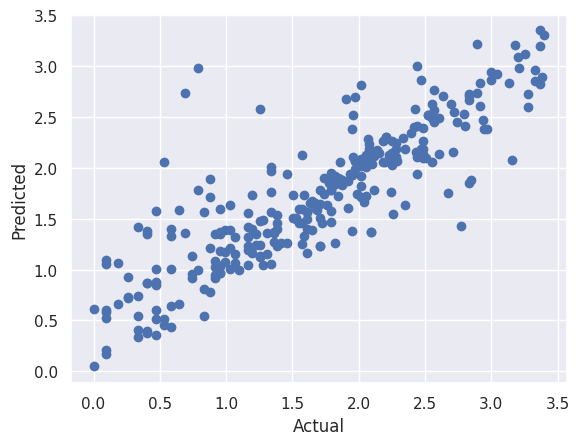

In [ ]:
plt.scatter(y_val,rf_pred1)
plt.xlabel('Actual')
plt.ylabel('Predicted')

<Axes: xlabel='Price_log'>

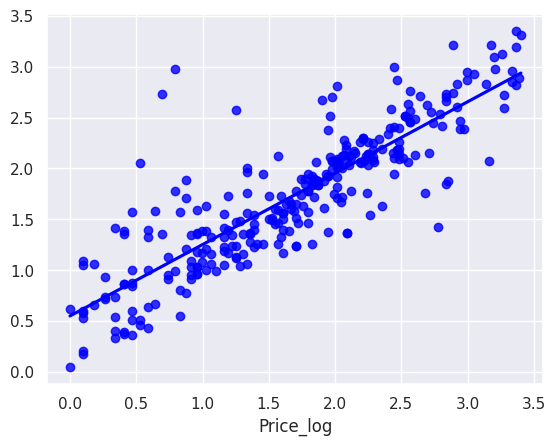

In [ ]:
sns.regplot(x=y_val,y=rf_pred1,ci=None,color ='blue')

In [ ]:
rf_mae1 = metrics.mean_absolute_error(y_val, rf_pred1)
rf_mse1 = metrics.mean_squared_error(y_val, rf_pred1)
rf_rmse1 = np.sqrt(metrics.mean_squared_error(y_val, rf_pred1))

In [ ]:
print(f'R2 Score: {rf_score1}, Explained Variance Score: {expl_rf1}, MAE: {rf_mae1}, MSE: {rf_mse1}, RMSE: {rf_rmse1}')

R2 Score: 0.7403851636824476, Explained Variance Score: 0.6106973943783243, MAE: 0.27837745307326484, MSE: 0.1793024668518206, RMSE: 0.4234412200669895


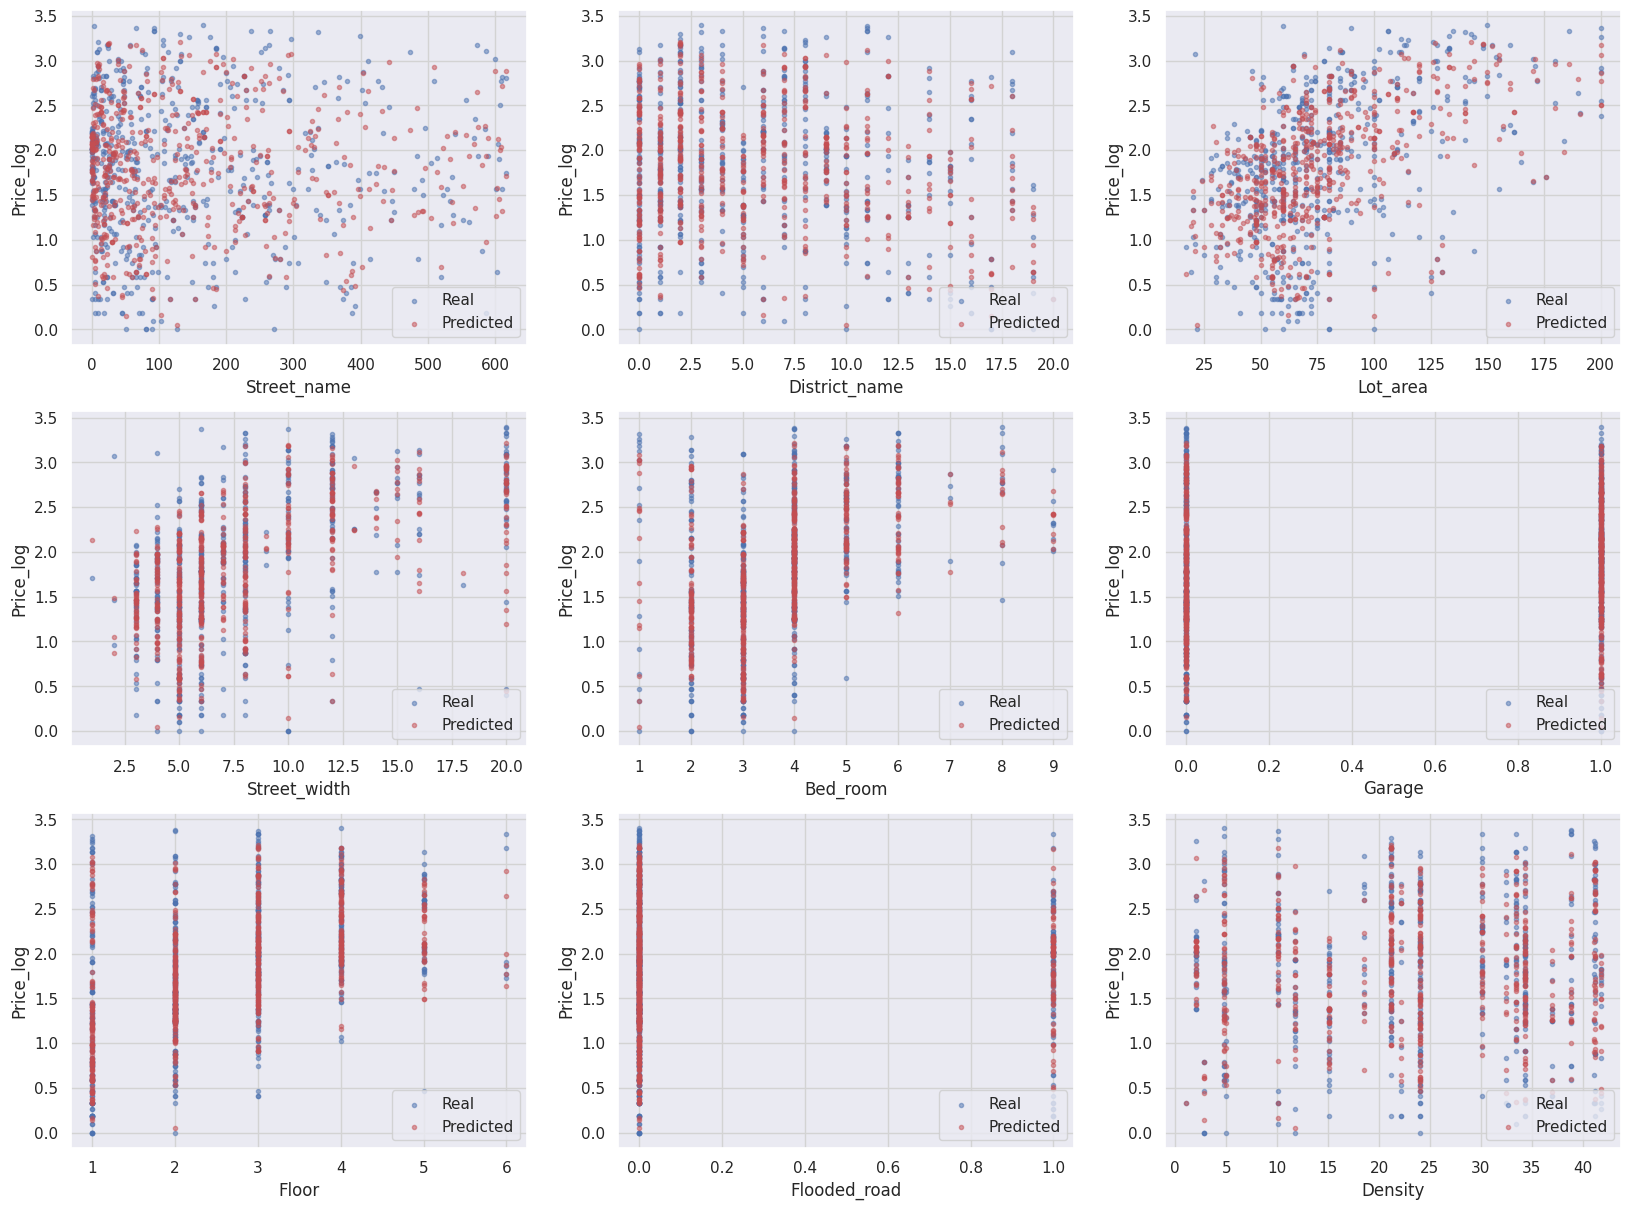

In [ ]:
plt.figure(figsize=(20,20))
def prediction(list_variables):
  x=1
  for i in list_variables:
    plt.subplot(4,3,x)
    plt.scatter(X_test[i], y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
    plt.scatter(X_test[i], rf_pred, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
    plt.xlabel(f'{i}')
    plt.ylabel('Price_log')
    plt.grid(color = '#D3D3D3', linestyle = 'solid')
    plt.legend(loc = 'lower right')
    x+=1
  #plt.savefig('prediction.png')
features = list(df2.columns)
features = [ elem for elem in features if elem != 'Price' and elem != 'Price_log']
prediction(features)

In [ ]:
n_estimators = list(range(50,550,50))   # 100 trường hợp từ 1 đến 100 Decision Trees để tạo 100 Random Forest Metrics.
param_grid = {
    'max_depth': list(range(5,55,5)),
    'n_estimators': n_estimators,
}
rf = RandomForestRegressor(random_state=0)
gs = GridSearchCV(rf, param_grid, cv=5, n_jobs = -1, verbose = 1)
gs.fit(X_train, y_train)
scores = gs.cv_results_['mean_test_score']
ind = np.where(scores == np.amax(scores))[0][0]+1

print(f'optimal params are {gs.best_params_} that accuracy is {scores.max()}')

# plt.plot(n_estimators, scores) không vẽ được vì x, y, z khác kích thước
# plt.xlabel('n_estimators')
# plt.ylabel('Accuracy')
#plt.savefig('accuracy_with_optiml_n_estimators.png')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
optimal params are {'max_depth': 20, 'n_estimators': 450} that accuracy is 0.7430975143418962


In [ ]:
rf_regressor2 = RandomForestRegressor(n_estimators=ind, max_depth=20, random_state=0)
rf_regressor2.fit(X_train,y_train)
rf_pred2 = rf_regressor2.predict(X_test)
rf_score2 = rf_regressor2.score(X_test,y_test)
expl_rf2 = explained_variance_score(rf_pred2,y_test)

Text(0, 0.5, 'Predicted')

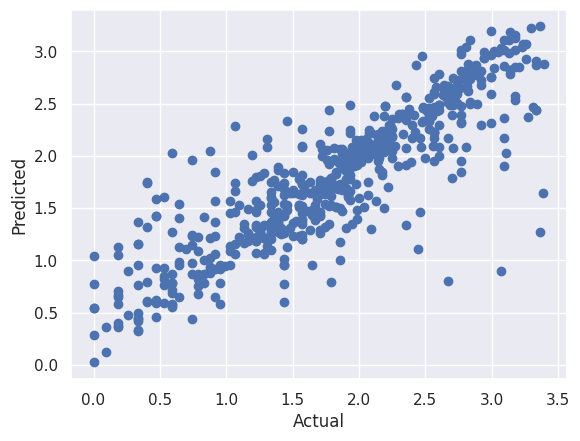

In [ ]:
plt.scatter(y_test,rf_pred2)
plt.xlabel('Actual')
plt.ylabel('Predicted')

<Axes: xlabel='Price_log'>

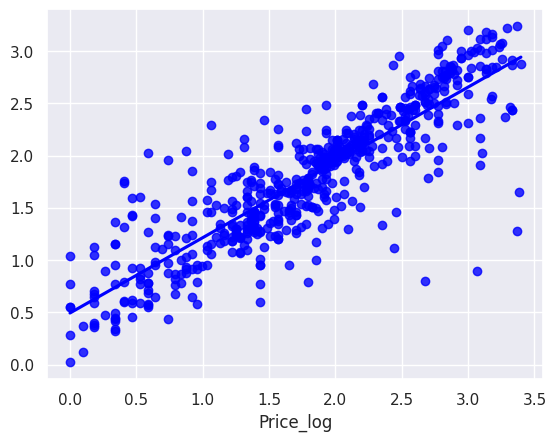

In [ ]:
sns.regplot(x=y_test,y=rf_pred2,ci=None,color ='blue')

In [ ]:
rf_mae2 = metrics.mean_absolute_error(y_test, rf_pred2)
rf_mse2 = metrics.mean_squared_error(y_test, rf_pred2)
rf_rmse2 = np.sqrt(metrics.mean_squared_error(y_test, rf_pred2))
print(f'R2 Score: {rf_score2}, Explained Variance Score: {expl_rf2}, MAE: {rf_mae2}, MSE: {rf_mse2}, RMSE: {rf_rmse2}')

R2 Score: 0.7541911032308772, Explained Variance Score: 0.6424415138963282, MAE: 0.25765988755134256, MSE: 0.1562648579396237, RMSE: 0.39530350104650436


In [ ]:
result2 = pd.DataFrame({'Actual': list(y_test), 'Predicted': rf_pred2.flatten(), 'Distance': rf_pred2.flatten()-list(y_test)})
print(result2.head(20))

      Actual  Predicted  Distance
0   1.974081   2.065898  0.091817
1   1.252763   1.298170  0.045407
2   0.641854   1.405307  0.763453
3   0.916291   1.848875  0.932584
4   1.335001   1.658700  0.323699
5   1.458615   1.124295 -0.334320
6   1.589235   1.663771  0.074536
7   1.568616   1.730954  0.162338
8   3.230804   3.044136 -0.186669
9   2.397895   2.175091 -0.222804
10  1.481605   1.305394 -0.176211
11  2.740840   2.656240 -0.084600
12  1.774952   2.442389  0.667436
13  1.458615   1.531523  0.072908
14  2.674149   2.511839 -0.162310
15  1.064711   1.153923  0.089212
16  0.788457   0.674351 -0.114106
17  2.208274   2.127923 -0.080351
18  0.000000   1.040017  1.040017
19  2.803360   2.748619 -0.054742
